In [4]:
!pip install xgboost -U -q
!pip install sklearn -U -q
!pip install shap
!pip install missingno
!pip install unidecode

     |████████████████████████████████| 193.6 MB 74 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 3.9 MB/s 


In [5]:
#Importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import shap
# from sklearn.utils import resample

# For SML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import itertools
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
import shap
from yellowbrick.features import FeatureImportances

# for scraping
from bs4 import BeautifulSoup
import requests

# for datacleaning
import unidecode

# for EDA
import missingno as msno

# Retrieving the relevant data from football reference.

In this part of the notebook we are scraping the data, from football referee for the current season. We decided to only include the current season, in order to get the most updated picture of the market value. We discussed including more historical data, due to the fact that the market value is build up over several seasons and not just a half. But still we want to make a model that predict the current value and we thought the newest data was more fitting.

This section includes
- Retrieval of relevant data
- Doing the initial filtering of variables such as absolute measures vs relative
- Renaming columns to more appropiate names
- Fixing the Age column to show only year
- Fixing the position column to only contain the main position

This was done for 6 stat categories relevant for field players and 2 relevant for goalkeepers, theese categories are named as such;
- Standard stas
- Miscellaneous stats
- Shooting
- Passing
- Defensive actions
- Goal and shot creation
- Goalkeeping
- Advanced goalkeeping

In [6]:
# Url for scraping purposes. Including different tables of stattypes like shooting, passing and so on
url_stats = 'https://fbref.com/en/comps/Big5/stats/players/Big-5-European-Leagues-Stats'
url_misc  = 'https://fbref.com/en/comps/Big5/misc/players/Big-5-European-Leagues-Stats' 
url_shoot = 'https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats'
url_pass  = 'https://fbref.com/en/comps/Big5/passing/players/Big-5-European-Leagues-Stats'
url_def = 'https://fbref.com/en/comps/Big5/defense/players/Big-5-European-Leagues-Stats'
url_crea = 'https://fbref.com/en/comps/Big5/gca/players/Big-5-European-Leagues-Stats'
url_gk = 'https://fbref.com/en/comps/Big5/keepers/players/Big-5-European-Leagues-Stats'
url_gkadv = 'https://fbref.com/en/comps/Big5/keepersadv/players/Big-5-European-Leagues-Stats'

In [7]:
# Minor leagues are imported from excel files. It's from the same website, meaning same features measured as in the top 5 leagues
df_stats_minor = pd.read_excel("https://github.com/madsejler/M3/blob/main/minor_stats.xlsx?raw=true")
df_misc_minor = pd.read_excel("https://github.com/madsejler/M3/blob/main/minor_misc.xlsx?raw=true")
df_shoot_minor = pd.read_excel("https://github.com/madsejler/M3/blob/main/minor_shoot.xlsx?raw=true")
df_pass_minor = pd.read_excel("https://github.com/madsejler/M3/blob/main/minor_pass.xlsx?raw=true")
df_def_minor = pd.read_excel("https://github.com/madsejler/M3/blob/main/minor_def.xlsx?raw=true")
df_crea_minor = pd.read_excel("https://github.com/madsejler/M3/blob/main/minor_crea.xlsx?raw=true")
df_gk_minor = pd.read_excel("https://github.com/madsejler/M3/blob/main/minor_gk.xlsx?raw=true")
df_gkadv_minor = pd.read_excel("https://github.com/madsejler/M3/blob/main/minor_gkadv.xlsx?raw=true")

## Standard Stats

In [8]:
# Scraping the general stats from the URL.
response = requests.get(url_stats)
soup = BeautifulSoup(response.text,"html.parser")
table = soup.find('table') 
headers = [ 'Player','Nation','Pos','Squad','Comp','Age','Born','MP', 'Starts', 'Min', '90s','Gls','Ast','G-PK','PK','PKatt','CrdY','CrdR','Gls 90','Ast 90','G+A 90','G-PK 90','G+A-PK 90','xG','npxG','xAG','npxG+xAG','xG 90','xAG 90','xG+xAG','npxG','npxG+xAG','Matches']
df_stats = pd.DataFrame(columns=headers)
i=0
for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [tr.text for tr in row_data]
    if row != []:
        df_stats.loc[i] = row
        i=i+1
df_stats

Player  Nation    Pos          Squad                Comp  \
0      Brenden Aaronson  us USA  MF,FW   Leeds United  eng Premier League   
1      Yunis Abdelhamid  ma MAR     DF          Reims          fr Ligue 1   
2         Himad Abdelli  fr FRA  MF,FW         Angers          fr Ligue 1   
3     Salis Abdul Samed  gh GHA     MF           Lens          fr Ligue 1   
4       Laurent Abergel  fr FRA     MF        Lorient          fr Ligue 1   
...                 ...     ...    ...            ...                 ...   
2378   Martín Zubimendi  es ESP     MF  Real Sociedad          es La Liga   
2379   Szymon Żurkowski  pl POL     MF     Fiorentina          it Serie A   
2380    Martin Ødegaard  no NOR     MF        Arsenal  eng Premier League   
2381        Milan Đurić  ba BIH     FW  Hellas Verona          it Serie A   
2382      Filip Đuričić  rs SRB  MF,FW      Sampdoria          it Serie A   

         Age  Born  MP Starts    Min  ...   xG npxG  xAG npxG+xAG xG 90  \
0     22-053  2000  14     14  1,189  ...  1.9  1.9  2.9      4.8  0.14   
1     35-077  1987  15     15  1,350  ...  1.3  1.3  0.2      1.6  0.09   
2     23-027  1999   7      2    231  ...  0.4  0.4  0.5      0.9  0.15   
3     22-263  2000  15     15  1,349  ...  0.3  0.3  0.4      0.7  0.02   
4     29-316  1993  10     10    807  ...  0.2  0.2  0.5      0.7  0.02   
...      ...   ...  ..    ...    ...  ...  ...  ...  ...      ...   ...   
2378  23-315  1999  14     13  1,151  ...  0.5  0.5  0.7      1.2  0.04   
2379  25-080  1997   2      0     32  ...  0.1  0.1  0.0      0.1  0.33   
2380  23-362  1998  13     13  1,074  ...  4.1  4.1  2.6      6.7  0.35   
2381  32-206  1990  11      2    283  ...  0.1  0.1  0.3      0.4  0.03   
2382  30-318  1992  15     13  1,010  ...  0.6  0.6  1.4      2.0  0.06   

     xAG 90 xG+xAG  npxG npxG+xAG  Matches  
0      0.22   0.36  0.14     0.36  Matches  
1      0.02   0.10  0.09     0.10  Matches  
2      0.21   0.36  0.15     0.36  Matches  
3      0.02   0.05  0.02     0.05  Matches  
4      0.06   0.08  0.02     0.08  Matches  
...     ...    ...   ...      ...      ...  
2378   0.05   0.10  0.04     0.10  Matches  
2379   0.06   0.40  0.33     0.40  Matches  
2380   0.22   0.56  0.35     0.56  Matches  
2381   0.11   0.14  0.03     0.14  Matches  
2382   0.12   0.18  0.06     0.18  Matches  

[2383 rows x 33 columns]

In [9]:
# Renaming the minor dataset to fit the top5 dataset and making sure that the feature names match
df_stats_minor = df_stats_minor.rename({"npxG.1":"npxG", "npxG+xAG.1": "npxG+xAG" }, axis=1)

In [10]:
# Merging top 5 leagues with minor leagues
df_stats = pd.concat([df_stats, df_stats_minor], axis=0)

In [11]:
# Checking the data
# Also noticing there are some missing values which will be dealt with later.
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3868 entries, 0 to 1484
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Player     3868 non-null   object
 1   Nation     3865 non-null   object
 2   Pos        3868 non-null   object
 3   Squad      3868 non-null   object
 4   Comp       3868 non-null   object
 5   Age        3865 non-null   object
 6   Born       3865 non-null   object
 7   MP         3868 non-null   object
 8   Starts     3868 non-null   object
 9   Min        3868 non-null   object
 10  90s        3868 non-null   object
 11  Gls        3868 non-null   object
 12  Ast        3868 non-null   object
 13  G-PK       3868 non-null   object
 14  PK         3868 non-null   object
 15  PKatt      3868 non-null   object
 16  CrdY       3868 non-null   object
 17  CrdR       3868 non-null   object
 18  Gls 90     3868 non-null   object
 19  Ast 90     3868 non-null   object
 20  G+A 90     3868 non-null   obj

In [12]:
# keeping relevant data and renaming columns which results in 14 columns. It is important to notice some columns will occur multiple times through out the different categories
# The removed are based on intuion based and what might be the most relevant.
# Also there often occur an relative and an absolute variable of pretty much the same,
# for example "goals" occur as and absolute and pr 90 minutes. We decided to keep the relative.

df_stats=df_stats.loc[:,['Player',"Nation",'Squad','Pos','Comp','Age',"MP",'Min','Gls 90','Ast 90','G+A 90',"xG 90" ,"xAG 90", "xG+xAG"]]
df_stats = df_stats.rename({'Player':"Player Name",'Pos': 'Positions',"Comp": "Competition", 'Gls': 'Goals', 'Ast':'Asists','G+A':'GoalAstPer90', 
                            "MP": "Matches Played", "Min":"Minutes Played", "xG+xAG": "xG+xAG 90" }, axis=1)

In [13]:
#Some of the players has multiple postions plays multiple positions, but we will only use their main positions which is the first written.
positions = df_stats['Positions'].str.split(pat = ',', expand = True)
positions.columns=["Position","2nd"]
positions=positions.drop("2nd", axis=1)
positions

Position
0          MF
1          DF
2          MF
3          MF
4          MF
...       ...
1480       FW
1481       FW
1482       DF
1483       MF
1484       FW

[3868 rows x 1 columns]

In [14]:
df_stats = df_stats.drop(["Positions"], axis=1)

In [15]:
#Combining the two dataframes back to one.
df_stats = pd.concat([df_stats, positions], axis=1)
df_stats

Player Name   Nation           Squad         Competition     Age  \
0      Brenden Aaronson   us USA    Leeds United  eng Premier League  22-053   
1      Yunis Abdelhamid   ma MAR           Reims          fr Ligue 1  35-077   
2         Himad Abdelli   fr FRA          Angers          fr Ligue 1  23-027   
3     Salis Abdul Samed   gh GHA            Lens          fr Ligue 1  22-263   
4       Laurent Abergel   fr FRA         Lorient          fr Ligue 1  29-316   
...                 ...      ...             ...                 ...     ...   
1480       Charlie Wyke  eng ENG  Wigan Athletic                 EFL  30-002   
1481        Jerry Yates  eng ENG       Blackpool                 EFL  26-028   
1482        Andy Yiadom   gh GHA         Reading                 EFL  31-006   
1483       Okay Yokuşlu   tr TUR       West Brom                 EFL  28-274   
1484      Anass Zaroury   ma MAR         Burnley                 EFL  22-031   

     Matches Played Minutes Played Gls 90 Ast 90 G+A 90 xG 90 xAG 90  \
0                14          1,189   0.08   0.15   0.23  0.14   0.22   
1                15          1,350   0.00   0.00   0.00  0.09   0.02   
2                 7            231   0.00   0.00   0.00  0.15   0.21   
3                15          1,349   0.07   0.00   0.07  0.02   0.02   
4                10            807   0.00   0.11   0.11  0.02   0.06   
...             ...            ...    ...    ...    ...   ...    ...   
1480             14            715   0.25   0.25    0.5  0.22   0.08   
1481             21           1841   0.44    0.1   0.54  0.28   0.09   
1482             19           1649    0.0    0.0    0.0  0.04   0.04   
1483             16           1037   0.09    0.0   0.09  0.13   0.05   
1484             13            823   0.44   0.22   0.66  0.15   0.29   

     xG+xAG 90 Position  
0         0.36       MF  
1         0.10       DF  
2         0.36       MF  
3         0.05       MF  
4         0.08       MF  
...        ...      ...  
1480       0.3       FW  
1481      0.37       FW  
1482      0.08       DF  
1483      0.18       MF  
1484      0.43       FW  

[3868 rows x 14 columns]

In [16]:
# Cleaning the age column to only contain year
Age = df_stats['Age'].str.split(pat = '-', expand = True)
Age.columns=["Age","days"]
Age = Age.drop("days", axis=1)
df_stats = df_stats.drop(["Age"], axis=1)
df_stats = pd.concat([df_stats, Age], axis=1)
df_stats

Player Name   Nation           Squad         Competition  \
0      Brenden Aaronson   us USA    Leeds United  eng Premier League   
1      Yunis Abdelhamid   ma MAR           Reims          fr Ligue 1   
2         Himad Abdelli   fr FRA          Angers          fr Ligue 1   
3     Salis Abdul Samed   gh GHA            Lens          fr Ligue 1   
4       Laurent Abergel   fr FRA         Lorient          fr Ligue 1   
...                 ...      ...             ...                 ...   
1480       Charlie Wyke  eng ENG  Wigan Athletic                 EFL   
1481        Jerry Yates  eng ENG       Blackpool                 EFL   
1482        Andy Yiadom   gh GHA         Reading                 EFL   
1483       Okay Yokuşlu   tr TUR       West Brom                 EFL   
1484      Anass Zaroury   ma MAR         Burnley                 EFL   

     Matches Played Minutes Played Gls 90 Ast 90 G+A 90 xG 90 xAG 90  \
0                14          1,189   0.08   0.15   0.23  0.14   0.22   
1                15          1,350   0.00   0.00   0.00  0.09   0.02   
2                 7            231   0.00   0.00   0.00  0.15   0.21   
3                15          1,349   0.07   0.00   0.07  0.02   0.02   
4                10            807   0.00   0.11   0.11  0.02   0.06   
...             ...            ...    ...    ...    ...   ...    ...   
1480             14            715   0.25   0.25    0.5  0.22   0.08   
1481             21           1841   0.44    0.1   0.54  0.28   0.09   
1482             19           1649    0.0    0.0    0.0  0.04   0.04   
1483             16           1037   0.09    0.0   0.09  0.13   0.05   
1484             13            823   0.44   0.22   0.66  0.15   0.29   

     xG+xAG 90 Position Age  
0         0.36       MF  22  
1         0.10       DF  35  
2         0.36       MF  23  
3         0.05       MF  22  
4         0.08       MF  29  
...        ...      ...  ..  
1480       0.3       FW  30  
1481      0.37       FW  26  
1482      0.08       DF  31  
1483      0.18       MF  28  
1484      0.43       FW  22  

[3868 rows x 14 columns]

Repeating this proces for every stat group


## Miscellaneous Stats

In [17]:
response = requests.get(url_misc)
soup = BeautifulSoup(response.text,"html.parser")
table = soup.find('table') 
headers = [ 'Player','Nation','Pos','Squad','Comp','Age','Born','90s','CrdY','CrdR','2CrdY','Fls','Fld','Off',
           'Crs','Int','TklW','PKwon','PKcon','OG','Recov','Won','Lost','Won%','Matches']
df_misc = pd.DataFrame(columns=headers)
i=0
for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [tr.text for tr in row_data]
    if row != []:
        df_misc.loc[i] = row
        i=i+1
df_misc

Player  Nation    Pos          Squad                Comp  \
0      Brenden Aaronson  us USA  MF,FW   Leeds United  eng Premier League   
1      Yunis Abdelhamid  ma MAR     DF          Reims          fr Ligue 1   
2         Himad Abdelli  fr FRA  MF,FW         Angers          fr Ligue 1   
3     Salis Abdul Samed  gh GHA     MF           Lens          fr Ligue 1   
4       Laurent Abergel  fr FRA     MF        Lorient          fr Ligue 1   
...                 ...     ...    ...            ...                 ...   
2378   Martín Zubimendi  es ESP     MF  Real Sociedad          es La Liga   
2379   Szymon Żurkowski  pl POL     MF     Fiorentina          it Serie A   
2380    Martin Ødegaard  no NOR     MF        Arsenal  eng Premier League   
2381        Milan Đurić  ba BIH     FW  Hellas Verona          it Serie A   
2382      Filip Đuričić  rs SRB  MF,FW      Sampdoria          it Serie A   

         Age  Born   90s CrdY CrdR  ... Int TklW PKwon PKcon OG Recov Won  \
0     22-053  2000  13.2    2    0  ...   1    6     0     0  0    68   6   
1     35-077  1987  15.0    1    0  ...  34   20     0     0  0    96  29   
2     23-027  1999   2.6    0    0  ...   3    0     0     0  0    17   2   
3     22-263  2000  15.0    2    0  ...  18   10     0     0  1    98   9   
4     29-316  1993   9.0    2    0  ...  12   17     0     0  0    51   2   
...      ...   ...   ...  ...  ...  ...  ..  ...   ...   ... ..   ...  ..   
2378  23-315  1999  12.8    4    0  ...  13   13     0     0  0    71  33   
2379  25-080  1997   0.4    0    0  ...   0    0     0     0  0     2   1   
2380  23-362  1998  11.9    2    0  ...   2    7     0     0  0    65   5   
2381  32-206  1990   3.1    2    0  ...   0    0     0     0  0     4  47   
2382  30-318  1992  11.2    5    0  ...   5   10     0     0  0    53   7   

     Lost  Won%  Matches  
0      17  26.1  Matches  
1      16  64.4  Matches  
2       4  33.3  Matches  
3       7  56.3  Matches  
4       2  50.0  Matches  
...   ...   ...      ...  
2378   11  75.0  Matches  
2379    1  50.0  Matches  
2380    9  35.7  Matches  
2381   16  74.6  Matches  
2382   11  38.9  Matches  

[2383 rows x 25 columns]

In [18]:
df_misc = pd.concat([df_misc,df_misc_minor], axis=0)

In [19]:
df_misc = df_misc.loc[:,['Player',"CrdY",'CrdR',"Fls", "Fld","Int", "Recov", "Won%", "Crs"]]
df_misc = df_misc.rename({"CrdY":"Yellow Cards",'CrdR':"Red Cards", "Fls": "Fouls commited","Fld":"Fouls Drawn", "Int":"Interceptions", 
                          "Won%":"Aerial Duels Won %", "Recov": "Loose Ball Recovered", "Crs": "Crosses" }, axis=1)
df_misc

Player Yellow Cards Red Cards Fouls commited Fouls Drawn  \
0      Brenden Aaronson            2         0              8          28   
1      Yunis Abdelhamid            1         0             19           9   
2         Himad Abdelli            0         0              3           6   
3     Salis Abdul Samed            2         0             37          22   
4       Laurent Abergel            2         0              7           9   
...                 ...          ...       ...            ...         ...   
1480    Zaydou Youssouf            2         0             16          16   
1481            Zarzana            0         0              1           7   
1482         Kévin Zohi            1         0              2           8   
1483     Nermin Zolotić            3         1              8           6   
1484     Emilijus Zubas            1         0              1           1   

     Interceptions Loose Ball Recovered Aerial Duels Won % Crosses  
0                1                   68               26.1      42  
1               34                   96               64.4       3  
2                3                   17               33.3       0  
3               18                   98               56.3       5  
4               12                   51               50.0       2  
...            ...                  ...                ...     ...  
1480            10                 59.0               47.1       3  
1481             2                  NaN                NaN      12  
1482             4                 30.0               24.0       9  
1483            14                 64.0               61.9       5  
1484             0                  4.0              100.0       0  

[3868 rows x 9 columns]

## Shooting

In [20]:
response = requests.get(url_shoot)
soup = BeautifulSoup(response.text,"html.parser")
table = soup.find('table') 
headers = [ 'Player','Nation','Pos','Squad','Comp','Age','Born','90s','Gls','Sh','SoT','SoT%','Sh/90','SoT/90','G/Sh'
            ,'G/SoT','Dist','FK','PK','PKatt','xG','npxG','npxG/Sh','G-xG','np:G-xG','Matches']
df_shooting = pd.DataFrame(columns=headers)
i=0
for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [tr.text for tr in row_data]
    if row != []:
        df_shooting.loc[i] = row
        i=i+1
df_shooting

Player  Nation    Pos          Squad                Comp  \
0      Brenden Aaronson  us USA  MF,FW   Leeds United  eng Premier League   
1      Yunis Abdelhamid  ma MAR     DF          Reims          fr Ligue 1   
2         Himad Abdelli  fr FRA  MF,FW         Angers          fr Ligue 1   
3     Salis Abdul Samed  gh GHA     MF           Lens          fr Ligue 1   
4       Laurent Abergel  fr FRA     MF        Lorient          fr Ligue 1   
...                 ...     ...    ...            ...                 ...   
2378   Martín Zubimendi  es ESP     MF  Real Sociedad          es La Liga   
2379   Szymon Żurkowski  pl POL     MF     Fiorentina          it Serie A   
2380    Martin Ødegaard  no NOR     MF        Arsenal  eng Premier League   
2381        Milan Đurić  ba BIH     FW  Hellas Verona          it Serie A   
2382      Filip Đuričić  rs SRB  MF,FW      Sampdoria          it Serie A   

         Age  Born   90s Gls  Sh  ...  Dist FK PK PKatt   xG npxG npxG/Sh  \
0     22-053  2000  13.2   1  19  ...  19.1  1  0     0  1.9  1.9    0.10   
1     35-077  1987  15.0   0  15  ...  12.0  0  0     0  1.3  1.3    0.09   
2     23-027  1999   2.6   0   3  ...  20.4  0  0     0  0.4  0.4    0.13   
3     22-263  2000  15.0   1   6  ...  23.6  0  0     0  0.3  0.3    0.05   
4     29-316  1993   9.0   0   4  ...  23.9  0  0     0  0.2  0.2    0.05   
...      ...   ...   ...  ..  ..  ...   ... .. ..   ...  ...  ...     ...   
2378  23-315  1999  12.8   1   5  ...  19.1  0  0     0  0.5  0.5    0.11   
2379  25-080  1997   0.4   0   2  ...  15.2  0  0     0  0.1  0.1    0.06   
2380  23-362  1998  11.9   6  30  ...  19.0  4  0     0  4.1  4.1    0.14   
2381  32-206  1990   3.1   0   3  ...   9.0  0  0     0  0.1  0.1    0.03   
2382  30-318  1992  11.2   2   8  ...  18.1  0  0     0  0.6  0.6    0.08   

      G-xG np:G-xG  Matches  
0     -0.9    -0.9  Matches  
1     -1.3    -1.3  Matches  
2     -0.4    -0.4  Matches  
3     +0.7    +0.7  Matches  
4     -0.2    -0.2  Matches  
...    ...     ...      ...  
2378  +0.5    +0.5  Matches  
2379  -0.1    -0.1  Matches  
2380  +1.9    +1.9  Matches  
2381  -0.1    -0.1  Matches  
2382  +1.4    +1.4  Matches  

[2383 rows x 26 columns]

In [21]:
df_shooting = pd.concat([df_shooting,df_shoot_minor], axis=0)

In [22]:
df_shooting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3868 entries, 0 to 1484
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Player   3868 non-null   object
 1   Nation   3865 non-null   object
 2   Pos      3868 non-null   object
 3   Squad    3868 non-null   object
 4   Comp     3868 non-null   object
 5   Age      3865 non-null   object
 6   Born     3865 non-null   object
 7   90s      3868 non-null   object
 8   Gls      3868 non-null   object
 9   Sh       3868 non-null   object
 10  SoT      3868 non-null   object
 11  SoT%     3594 non-null   object
 12  Sh/90    3868 non-null   object
 13  SoT/90   3868 non-null   object
 14  G/Sh     3594 non-null   object
 15  G/SoT    3311 non-null   object
 16  Dist     3590 non-null   object
 17  FK       3863 non-null   object
 18  PK       3868 non-null   object
 19  PKatt    3868 non-null   object
 20  xG       3863 non-null   object
 21  npxG     3863 non-null   object
 22  

In [23]:
df_shooting = df_shooting.loc[:,['Player','SoT/90','Sh/90', 'G/Sh', "G/SoT","Dist"]]
df_shooting = df_shooting.rename({"SoT/90":"Shots on Target pr 90", "Sh/90":"Shots Total pr 90","G/Sh":"Goals pr shot","G/SoT":"Goals pr Shot on target", "Dist":"Average shooting distance"}, axis=1)
df_shooting

Player Shots on Target pr 90 Shots Total pr 90 Goals pr shot  \
0      Brenden Aaronson                  0.30              1.44          0.05   
1      Yunis Abdelhamid                  0.00              1.00          0.00   
2         Himad Abdelli                  0.78              1.17          0.00   
3     Salis Abdul Samed                  0.07              0.40          0.17   
4       Laurent Abergel                  0.00              0.45          0.00   
...                 ...                   ...               ...           ...   
1480       Charlie Wyke                  0.38              1.51          0.17   
1481        Jerry Yates                  0.88              1.86          0.24   
1482        Andy Yiadom                   0.0              0.38           0.0   
1483       Okay Yokuşlu                  0.35              1.04          0.08   
1484      Anass Zaroury                  0.77              1.75          0.25   

     Goals pr Shot on target Average shooting distance  
0                       0.25                      19.1  
1                                                 12.0  
2                       0.00                      20.4  
3                       1.00                      23.6  
4                                                 23.9  
...                      ...                       ...  
1480                    0.67                      13.5  
1481                     0.5                      13.3  
1482                     NaN                      15.0  
1483                    0.25                      15.2  
1484                    0.57                      19.0  

[3868 rows x 6 columns]

In [24]:
df_shooting

Player Shots on Target pr 90 Shots Total pr 90 Goals pr shot  \
0      Brenden Aaronson                  0.30              1.44          0.05   
1      Yunis Abdelhamid                  0.00              1.00          0.00   
2         Himad Abdelli                  0.78              1.17          0.00   
3     Salis Abdul Samed                  0.07              0.40          0.17   
4       Laurent Abergel                  0.00              0.45          0.00   
...                 ...                   ...               ...           ...   
1480       Charlie Wyke                  0.38              1.51          0.17   
1481        Jerry Yates                  0.88              1.86          0.24   
1482        Andy Yiadom                   0.0              0.38           0.0   
1483       Okay Yokuşlu                  0.35              1.04          0.08   
1484      Anass Zaroury                  0.77              1.75          0.25   

     Goals pr Shot on target Average shooting distance  
0                       0.25                      19.1  
1                                                 12.0  
2                       0.00                      20.4  
3                       1.00                      23.6  
4                                                 23.9  
...                      ...                       ...  
1480                    0.67                      13.5  
1481                     0.5                      13.3  
1482                     NaN                      15.0  
1483                    0.25                      15.2  
1484                    0.57                      19.0  

[3868 rows x 6 columns]

## Passing

In [25]:
response = requests.get(url_pass)
soup = BeautifulSoup(response.text,"html.parser")
table = soup.find('table') 
headers = ['Player','Nation','Pos','Squad','Comp','Age','Born','90s','Passes Completed','Attemted Passes','Pass Completion %','Total Distance Passes have travelled',
           'PrgDistTot','Short passes Cmp','Short passes Att','Short Cmp %','Medium passes Cmp','Medium passes ATT','Medium Cmp%','Long passes Cmp','Long passes Att','Long Cmp%',
           'Assist','xAG', 'xA','A-xA','Passes lead to shot','Completed passes into 1/3 offensive pitch','Completed passes into penalty area','Completed crosses into penalty area',
           'Progressive passes','Matches']
df_pass = pd.DataFrame(columns=headers)
i=0
for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [tr.text for tr in row_data]
    if row != []:
        df_pass.loc[i] = row
        i=i+1
df_pass

Player  Nation    Pos          Squad                Comp  \
0      Brenden Aaronson  us USA  MF,FW   Leeds United  eng Premier League   
1      Yunis Abdelhamid  ma MAR     DF          Reims          fr Ligue 1   
2         Himad Abdelli  fr FRA  MF,FW         Angers          fr Ligue 1   
3     Salis Abdul Samed  gh GHA     MF           Lens          fr Ligue 1   
4       Laurent Abergel  fr FRA     MF        Lorient          fr Ligue 1   
...                 ...     ...    ...            ...                 ...   
2378   Martín Zubimendi  es ESP     MF  Real Sociedad          es La Liga   
2379   Szymon Żurkowski  pl POL     MF     Fiorentina          it Serie A   
2380    Martin Ødegaard  no NOR     MF        Arsenal  eng Premier League   
2381        Milan Đurić  ba BIH     FW  Hellas Verona          it Serie A   
2382      Filip Đuričić  rs SRB  MF,FW      Sampdoria          it Serie A   

         Age  Born   90s Passes Completed Attemted Passes  ... Assist  xAG  \
0     22-053  2000  13.2              334             446  ...      2  2.9   
1     35-077  1987  15.0              516             641  ...      0  0.2   
2     23-027  1999   2.6              112             142  ...      0  0.5   
3     22-263  2000  15.0              830             909  ...      0  0.4   
4     29-316  1993   9.0              339             378  ...      1  0.5   
...      ...   ...   ...              ...             ...  ...    ...  ...   
2378  23-315  1999  12.8              562             669  ...      2  0.7   
2379  25-080  1997   0.4               17              19  ...      1  0.0   
2380  23-362  1998  11.9              461             592  ...      2  2.6   
2381  32-206  1990   3.1               53             107  ...      0  0.3   
2382  30-318  1992  11.2              282             372  ...      0  1.4   

       xA  A-xA Passes lead to shot Completed passes into 1/3 offensive pitch  \
0     1.4  -0.9                  27                                        27   
1     0.3  -0.2                   4                                        41   
2     0.1  -0.5                   6                                        14   
3     0.9  -0.4                   9                                        81   
4     0.5  +0.5                   7                                        33   
...   ...   ...                 ...                                       ...   
2378  0.6  +1.3                   6                                        70   
2379  0.0  +1.0                   1                                         1   
2380  2.9  -0.6                  25                                        43   
2381  0.1  -0.3                   4                                         2   
2382  1.1  -1.4                  21                                        31   

     Completed passes into penalty area Completed crosses into penalty area  \
0                                     7                                   2   
1                                     2                                   0   
2                                     4                                   0   
3                                     9                                   1   
4                                     2                                   0   
...                                 ...                                 ...   
2378                                  8                                   0   
2379                                  1                                   0   
2380                                 25                                   1   
2381                                  1                                   0   
2382                                 15                                   3   

     Progressive passes  Matches  
0                    28  Matches  
1                    46  Matches  
2                    15  Matches  
3                    58  Matches  
4                    27  Matches  
...                 ...

In [26]:
df_pass = pd.concat([df_pass,df_pass_minor], axis=0)

In [27]:
df_pass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3868 entries, 0 to 1484
Data columns (total 32 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Player                                     3868 non-null   object
 1   Nation                                     3865 non-null   object
 2   Pos                                        3868 non-null   object
 3   Squad                                      3868 non-null   object
 4   Comp                                       3868 non-null   object
 5   Age                                        3865 non-null   object
 6   Born                                       3865 non-null   object
 7   90s                                        3868 non-null   object
 8   Passes Completed                           3863 non-null   object
 9   Attemted Passes                            3863 non-null   object
 10  Pass Completion %                   

In [28]:
df_pass = df_pass.loc[:,["Player","Pass Completion %",'Short Cmp %','Medium Cmp%', "Long Cmp%",  "Passes lead to shot", 
                         "Completed passes into 1/3 offensive pitch","Completed passes into penalty area","Completed crosses into penalty area",
                         "Progressive passes"]]
df_pass

Player Pass Completion % Short Cmp % Medium Cmp% Long Cmp%  \
0      Brenden Aaronson              74.9        82.4        77.1      38.5   
1      Yunis Abdelhamid              80.5        84.3        89.7      54.9   
2         Himad Abdelli              78.9        81.0        79.7      77.8   
3     Salis Abdul Samed              91.3        92.1        95.0      78.3   
4       Laurent Abergel              89.7        94.6        89.5      77.1   
...                 ...               ...         ...         ...       ...   
1480       Charlie Wyke              58.0        63.0        57.9      50.0   
1481        Jerry Yates              74.0        80.0        78.3      70.7   
1482        Andy Yiadom              73.2        87.4        75.1      43.4   
1483       Okay Yokuşlu              81.9        89.0        83.2      64.5   
1484      Anass Zaroury              64.3        85.1        65.0      34.1   

     Passes lead to shot Completed passes into 1/3 offensive pitch  \
0                     27                                        27   
1                      4                                        41   
2                      6                                        14   
3                      9                                        81   
4                      7                                        33   
...                  ...                                       ...   
1480                 5.0                                      12.0   
1481                19.0                                      18.0   
1482                11.0                                      59.0   
1483                 7.0                                      51.0   
1484                15.0                                       6.0   

     Completed passes into penalty area Completed crosses into penalty area  \
0                                     7                                   2   
1                                     2                                   0   
2                                     4                                   0   
3                                     9                                   1   
4                                     2                                   0   
...                                 ...                                 ...   
1480                                2.0                                 0.0   
1481                               10.0                                 0.0   
1482                               10.0                                 4.0   
1483                                5.0                                 2.0   
1484                               22.0                                12.0   

     Progressive passes  
0                    28  
1                    46  
2                    15  
3                    58  
4                    27  
...                 ...  
1480                9.0  
1481               28.0  
1482               42.0  
1483               43.0  
1484               14.0  

[3868 rows x 10 columns]

## Defensive actions

In [29]:
response = requests.get(url_def)
soup = BeautifulSoup(response.text,"html.parser")
table = soup.find('table') 
headers = ['Player','Nation','Pos','Squad','Comp','Age','Born','90s','Tackles','Tackles won possesion of ball',
           'Tackles Def 3rd','Tackles Mid 3rd','Tackles Att 3rd','Dribbling players tackled','Dribbles attempted against','Tackle succes %','Number of times dribbled',
           'Blocks total (shots+passes)','Shots blocked','Passes blocked','Interceptions','Tackles+Interceptions','Clearances','Errors leading to opposing team shot','Matches']
df_def = pd.DataFrame(columns=headers)
i=0
for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [tr.text for tr in row_data]
    if row != []:
        df_def.loc[i] = row
        i=i+1
df_def

Player  Nation    Pos          Squad                Comp  \
0      Brenden Aaronson  us USA  MF,FW   Leeds United  eng Premier League   
1      Yunis Abdelhamid  ma MAR     DF          Reims          fr Ligue 1   
2         Himad Abdelli  fr FRA  MF,FW         Angers          fr Ligue 1   
3     Salis Abdul Samed  gh GHA     MF           Lens          fr Ligue 1   
4       Laurent Abergel  fr FRA     MF        Lorient          fr Ligue 1   
...                 ...     ...    ...            ...                 ...   
2378   Martín Zubimendi  es ESP     MF  Real Sociedad          es La Liga   
2379   Szymon Żurkowski  pl POL     MF     Fiorentina          it Serie A   
2380    Martin Ødegaard  no NOR     MF        Arsenal  eng Premier League   
2381        Milan Đurić  ba BIH     FW  Hellas Verona          it Serie A   
2382      Filip Đuričić  rs SRB  MF,FW      Sampdoria          it Serie A   

         Age  Born   90s Tackles Tackles won possesion of ball  ...  \
0     22-053  2000  13.2      24                             6  ...   
1     35-077  1987  15.0      33                            20  ...   
2     23-027  1999   2.6       5                             0  ...   
3     22-263  2000  15.0      22                            10  ...   
4     29-316  1993   9.0      32                            17  ...   
...      ...   ...   ...     ...                           ...  ...   
2378  23-315  1999  12.8      23                            13  ...   
2379  25-080  1997   0.4       0                             0  ...   
2380  23-362  1998  11.9      12                             7  ...   
2381  32-206  1990   3.1       0                             0  ...   
2382  30-318  1992  11.2      18                            10  ...   

     Tackle succes % Number of times dribbled Blocks total (shots+passes)  \
0               33.3                       16                          21   
1               78.9                        4                          30   
2              100.0                        0                           0   
3               60.9                        9                          17   
4               37.0                       17                          12   
...              ...                      ...                         ...   
2378            53.8                        6                          16   
2379                                        0                           0   
2380            20.0                        8                           6   
2381                                        0                           2   
2382            41.7                        7                           4   

     Shots blocked Passes blocked Interceptions Tackles+Interceptions  \
0                1             20             1                    25   
1               12             18            34                    67   
2                0              0             3                     8   
3                4             13            18                    40   
4                2             10            12                    44   
...            ...            ...           ...                   ...   
2378             8              8            13                    36   
2379             0              0             0                     0   
2380             1              5             2                    14   
2381             1              1             0                     0   
2382             0              4             5                    23   

     Clearances Errors leading to opposing team shot  Matches  
0             5                                    0  Matches  
1            43                                    0  Matches  
2             2                                    0  Matches  
3            13                                    0  Matches  
4            10                                    0  Matches  
...         ...                                  ... 

In [30]:
df_def = pd.concat([df_def,df_def_minor], axis=0)

In [31]:
df_def = df_def.loc[:,['Player','Tackles','Tackles won possesion of ball',
           'Tackles Def 3rd','Tackles Mid 3rd','Tackles Att 3rd','Tackle succes %',
           'Number of times dribbled',"Blocks total (shots+passes)",'Shots blocked','Passes blocked','Clearances']]
df_def

Player Tackles Tackles won possesion of ball Tackles Def 3rd  \
0      Brenden Aaronson      24                             6               8   
1      Yunis Abdelhamid      33                            20              17   
2         Himad Abdelli       5                             0               0   
3     Salis Abdul Samed      22                            10               8   
4       Laurent Abergel      32                            17              23   
...                 ...     ...                           ...             ...   
1480       Charlie Wyke     2.0                             1             2.0   
1481        Jerry Yates    18.0                            10             4.0   
1482        Andy Yiadom    39.0                            22            24.0   
1483       Okay Yokuşlu    29.0                            16            13.0   
1484      Anass Zaroury    11.0                             8             3.0   

     Tackles Mid 3rd Tackles Att 3rd Tackle succes % Number of times dribbled  \
0                 13               3            33.3                       16   
1                 16               0            78.9                        4   
2                  5               0           100.0                        0   
3                 12               2            60.9                        9   
4                  9               0            37.0                       17   
...              ...             ...             ...                      ...   
1480             0.0             0.0            50.0                      1.0   
1481            10.0             4.0            44.0                     14.0   
1482            14.0             1.0            50.0                     14.0   
1483            14.0             2.0            66.7                      8.0   
1484             7.0             1.0            46.2                      7.0   

     Blocks total (shots+passes) Shots blocked Passes blocked Clearances  
0                             21             1             20          5  
1                             30            12             18         43  
2                              0             0              0          2  
3                             17             4             13         13  
4                             12             2             10         10  
...                          ...           ...            ...        ...  
1480                         0.0           0.0            0.0        7.0  
1481                        24.0           3.0           21.0       24.0  
1482                        11.0           5.0            6.0       34.0  
1483                        15.0           6.0            9.0       20.0  
1484                         6.0           1.0            5.0        3.0  

[3868 rows x 12 columns]

## Goal and Shot Creation stats

In [32]:
response = requests.get(url_crea)
soup = BeautifulSoup(response.text,"html.parser")
table = soup.find('table') 
headers = ['Player','Nation','Pos','Squad','Comp','Age','Born','90s','Shot creating actions','Shot creating actions 90','Completed liveball passes lead to shot',
           'Completed deadball passes lead to shot','Succesfull dribbles lead to shot','Shot lead to another shot','Fouls Drawn lead to shot',
           'Defensive actions lead to shot','Goal Creating Actions','Goal Creating Action 90','liveball passes lead to goal','Deadball passes lead to goal','Dribbles lead to goal',
           'Shots that lead goal scoring shot','Fouls drawn lead to goal','Defensive actions lead to goal','Matches']
df_crea = pd.DataFrame(columns=headers)
i=0
for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [tr.text for tr in row_data]
    if row != []:
        df_crea.loc[i] = row
        i=i+1
df_crea

Player  Nation    Pos          Squad                Comp  \
0      Brenden Aaronson  us USA  MF,FW   Leeds United  eng Premier League   
1      Yunis Abdelhamid  ma MAR     DF          Reims          fr Ligue 1   
2         Himad Abdelli  fr FRA  MF,FW         Angers          fr Ligue 1   
3     Salis Abdul Samed  gh GHA     MF           Lens          fr Ligue 1   
4       Laurent Abergel  fr FRA     MF        Lorient          fr Ligue 1   
...                 ...     ...    ...            ...                 ...   
2378   Martín Zubimendi  es ESP     MF  Real Sociedad          es La Liga   
2379   Szymon Żurkowski  pl POL     MF     Fiorentina          it Serie A   
2380    Martin Ødegaard  no NOR     MF        Arsenal  eng Premier League   
2381        Milan Đurić  ba BIH     FW  Hellas Verona          it Serie A   
2382      Filip Đuričić  rs SRB  MF,FW      Sampdoria          it Serie A   

         Age  Born   90s Shot creating actions Shot creating actions 90  ...  \
0     22-053  2000  13.2                    51                     3.86  ...   
1     35-077  1987  15.0                    16                     1.07  ...   
2     23-027  1999   2.6                     9                     3.51  ...   
3     22-263  2000  15.0                    18                     1.20  ...   
4     29-316  1993   9.0                    13                     1.45  ...   
...      ...   ...   ...                   ...                      ...  ...   
2378  23-315  1999  12.8                    15                     1.17  ...   
2379  25-080  1997   0.4                     2                     5.63  ...   
2380  23-362  1998  11.9                    54                     4.53  ...   
2381  32-206  1990   3.1                     7                     2.23  ...   
2382  30-318  1992  11.2                    42                     3.75  ...   

     Defensive actions lead to shot Goal Creating Actions  \
0                                 1                     5   
1                                 2                     2   
2                                 1                     0   
3                                 1                     0   
4                                 1                     1   
...                             ...                   ...   
2378                              0                     4   
2379                              0                     1   
2380                              0                     4   
2381                              0                     0   
2382                              0                     1   

     Goal Creating Action 90 liveball passes lead to goal  \
0                       0.38                            3   
1                       0.13                            1   
2                       0.00                            0   
3                       0.00                            0   
4                       0.11                            1   
...                      ...                          ...   
2378                    0.31                            4   
2379                    2.81                            1   
2380                    0.34                            4   
2381                    0.00                            0   
2382                    0.09                            1   

     Deadball passes lead to goal Dribbles lead to goal  \
0                               0                     0   
1                               0                     0   
2                               0                     0   
3                               0                     0   
4                               0                     0   
...                           ...                   ...   
2378                            0                     0   
2379                            0                     0   
2380                            0                     0   
2381                            0                     0   
2382            

In [33]:
df_crea.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2383 entries, 0 to 2382
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Player                                  2383 non-null   object
 1   Nation                                  2383 non-null   object
 2   Pos                                     2383 non-null   object
 3   Squad                                   2383 non-null   object
 4   Comp                                    2383 non-null   object
 5   Age                                     2383 non-null   object
 6   Born                                    2383 non-null   object
 7   90s                                     2383 non-null   object
 8   Shot creating actions                   2383 non-null   object
 9   Shot creating actions 90                2383 non-null   object
 10  Completed liveball passes lead to shot  2383 non-null   object
 11  Comp

In [34]:
df_crea = pd.concat([df_crea,df_crea_minor], axis=0)

In [35]:
df_crea = df_crea.loc[:,['Player','Shot creating actions 90','Completed liveball passes lead to shot',
           'Completed deadball passes lead to shot','Succesfull dribbles lead to shot','Shot lead to another shot','Fouls Drawn lead to shot',
           'Defensive actions lead to shot','Goal Creating Action 90','liveball passes lead to goal','Deadball passes lead to goal','Dribbles lead to goal',
           'Shots that lead goal scoring shot','Fouls drawn lead to goal','Defensive actions lead to goal']]
df_crea

Player Shot creating actions 90  \
0      Brenden Aaronson                     3.86   
1      Yunis Abdelhamid                     1.07   
2         Himad Abdelli                     3.51   
3     Salis Abdul Samed                     1.20   
4       Laurent Abergel                     1.45   
...                 ...                      ...   
1480       Charlie Wyke                     1.76   
1481        Jerry Yates                      2.2   
1482        Andy Yiadom                     1.64   
1483       Okay Yokuşlu                     1.65   
1484      Anass Zaroury                     2.08   

     Completed liveball passes lead to shot  \
0                                        35   
1                                        12   
2                                         7   
3                                        17   
4                                        11   
...                                     ...   
1480                                   12.0   
1481                                   36.0   
1482                                   21.0   
1483                                   16.0   
1484                                   18.0   

     Completed deadball passes lead to shot Succesfull dribbles lead to shot  \
0                                         7                                3   
1                                         0                                0   
2                                         0                                0   
3                                         0                                0   
4                                         0                                0   
...                                     ...                              ...   
1480                                    0.0                              0.0   
1481                                    0.0                              3.0   
1482                                    1.0                              1.0   
1483                                    0.0                              2.0   
1484                                    1.0                              0.0   

     Shot lead to another shot Fouls Drawn lead to shot  \
0                            2                        3   
1                            2                        0   
2                            1                        0   
3                            0                        0   
4                            1                        0   
...                        ...                      ...   
1480                       0.0                      2.0   
1481                       6.0                      0.0   
1482                       3.0                      3.0   
1483                       1.0                      0.0   
1484                       0.0                      0.0   

     Defensive actions lead to shot Goal Creating Action 90  \
0                                 1                    0.38   
1                                 2                    0.13   
2                                 1                    0.00   
3                                 1                    0.00   
4                                 1                    0.11   
...                             ...                     ...   
1480                            0.0                    0.25   
1481                            0.0                    0.15   
1482                            1.0                    0.11   
1483                            0.0                    0.17   
1484                            0.0                    0.33   

     liveball passes lead to goal Deadball passes lead to goal  \
0                               3                            0   
1                               1                            0   
2                               0                            0   
3                               0                            0   
4                               1                            0   
... 

## Goalkeeping stats

In [36]:
response = requests.get(url_gk)
soup = BeautifulSoup(response.text,"html.parser")
table = soup.find('table') 
headers = [ 'Player Name','Nation','Position','Squad','Competetion','Age','Born','Matches Played', 'Starts', 'Minutes Played', '90s = (Minutes / 90)','Goals Against','Goals Against 90',
           'Shot on target against','Saves','Save%','Wins','Drawn','Losses','Clean Sheets','Clean Sheet%', 'Penalty kicks attempted against','Penalty kicks allowed',
           'Penalty kicks saved','Penalty kicks missed','Penalty kicks Saved %','Matches']
df_gk = pd.DataFrame(columns=headers)
i=0
for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [tr.text for tr in row_data]
    if row != []:
        df_gk.loc[i] = row
        i=i+1
df_gk

Player Name   Nation Position           Squad         Competetion  \
0        Doğan Alemdar   tr TUR       GK          Rennes          fr Ligue 1   
1              Alisson   br BRA       GK       Liverpool  eng Premier League   
2      Alphonse Areola   fr FRA       GK        West Ham  eng Premier League   
3    Kepa Arrizabalaga   es ESP       GK         Chelsea  eng Premier League   
4        Sergio Asenjo   es ESP       GK      Valladolid          es La Liga   
..                 ...      ...      ...             ...                 ...   
142  Guglielmo Vicario   it ITA       GK          Empoli          it Serie A   
143         Danny Ward  wls WAL       GK  Leicester City  eng Premier League   
144      Robin Zentner   de GER       GK        Mainz 05       de Bundesliga   
145   Michael Zetterer   de GER       GK   Werder Bremen       de Bundesliga   
146        Jeroen Zoet   nl NED       GK          Spezia          it Serie A   

        Age  Born Matches Played Starts Minutes Played  ... Drawn Losses  \
0    20-046  2002              3      2            225  ...     0      1   
1    30-073  1992             14     14          1,260  ...     4      4   
2    29-290  1993              2      0            107  ...     0      0   
3    28-072  1994              6      6            495  ...     2      0   
4    33-169  1989              5      5            450  ...     1      3   
..      ...   ...            ...    ...            ...  ...   ...    ...   
142  26-068  1996             15     15          1,350  ...     5      6   
143  29-175  1993             15     15          1,350  ...     2      8   
144  28-047  1994             15     15          1,350  ...     4      6   
145  27-155  1995              1      0             62  ...     0      0   
146  31-342  1991              2      1            138  ...     1      0   

    Clean Sheets Clean Sheet% Penalty kicks attempted against  \
0              0          0.0                               1   
1              4         28.6                               3   
2              0                                            1   
3              3         50.0                               0   
4              1         20.0                               0   
..           ...          ...                             ...   
142            5         33.3                               3   
143            6         40.0                               1   
144            4         26.7                               2   
145            0                                            0   
146            0          0.0                               0   

    Penalty kicks allowed Penalty kicks saved Penalty kicks missed  \
0                       0                   1                    0   
1                       2                   1                    0   
2                       1                   0                    0   
3                       0                   0                    0   
4                       0                   0                    0   
..                    ...                 ...                  ...   
142                     1                   1                    1   
143                     1                   0                    0   
144                     0                   1                    1   
145                     0                   0                    0   
146                     0                   0                    0   

    Penalty kicks Saved %  Matches  
0                   100.0  Matches  
1                    33.3  Matches  
2                     0.0  Matches  
3                          Matches  
4                          Matches  
..                    ...      ...  
142                  50.0  Matches  
143                   0.0  Matches  
144                 100.0  Matches  
145                        Matches  
146                        Matches  

[147 rows x 27 columns]

In [37]:
df_gk = pd.concat([df_gk,df_gk_minor], axis=0)

In [38]:
df_gk = df_gk.loc[:,['Player Name','Nation','Position','Squad','Competetion','Age','Matches Played', 'Minutes Played','Goals Against 90'
           ,'Save%','Wins','Drawn','Losses','Clean Sheet%', 'Penalty kicks attempted against','Penalty kicks Saved %']]
df_gk

Player Name  Nation Position       Squad         Competetion  \
0          Doğan Alemdar  tr TUR       GK      Rennes          fr Ligue 1   
1                Alisson  br BRA       GK   Liverpool  eng Premier League   
2        Alphonse Areola  fr FRA       GK    West Ham  eng Premier League   
3      Kepa Arrizabalaga  es ESP       GK     Chelsea  eng Premier League   
4          Sergio Asenjo  es ESP       GK  Valladolid          es La Liga   
..                   ...     ...      ...         ...                 ...   
91          Matouš Trmal  cz CZE       GK    Marítimo                 PRI   
92          Bruno Varela  pt POR       GK     Vitória                 PRI   
93            Igor Vekič  si SVN       GK       Paços                 PRI   
94  Odisseas Vlachodimos  gr GRE       GK     Benfica                 PRI   
95        Emilijus Zubas  lt LTU       GK      Arouca                 PRI   

       Age Matches Played Minutes Played Goals Against 90 Save% Wins Drawn  \
0   20-046              3            225             1.60  50.0    1     0   
1   30-073             14          1,260             1.21  76.2    6     4   
2   29-290              2            107             1.68  50.0    0     0   
3   28-072              6            495             0.91  80.0    3     2   
4   33-169              5            450             1.40  41.7    1     1   
..     ...            ...            ...              ...   ...  ...   ...   
91  24-068              6            540             0.83  84.6    1     3   
92  28-035             13           1170              1.0  72.9    7     2   
93  24-217              6            540              1.5  50.0    0     2   
94  28-227             13           1170             0.54  76.0   12     1   
95  32-152              3            270             1.33  70.0    0     2   

   Losses Clean Sheet% Penalty kicks attempted against Penalty kicks Saved %  
0       1          0.0                               1                 100.0  
1       4         28.6                               3                  33.3  
2       0                                            1                   0.0  
3       0         50.0                               0                        
4       3         20.0                               0                        
..    ...          ...                             ...                   ...  
91      2         33.3                               1                   0.0  
92      4         46.2                               1                   NaN  
93      4          0.0                               0                   NaN  
94      0         61.5                               1                   0.0  
95      1         33.3                               1                   0.0  

[243 rows x 16 columns]

In [39]:
Age = df_gk['Age'].str.split(pat = '-', expand = True)
Age.columns=["Age","days"]
Age = Age.drop("days", axis=1)
df_gk = df_gk.drop(["Age"], axis=1)
df_gk = pd.concat([df_gk, Age], axis=1)
df_gk

Player Name  Nation Position       Squad         Competetion  \
0          Doğan Alemdar  tr TUR       GK      Rennes          fr Ligue 1   
1                Alisson  br BRA       GK   Liverpool  eng Premier League   
2        Alphonse Areola  fr FRA       GK    West Ham  eng Premier League   
3      Kepa Arrizabalaga  es ESP       GK     Chelsea  eng Premier League   
4          Sergio Asenjo  es ESP       GK  Valladolid          es La Liga   
..                   ...     ...      ...         ...                 ...   
91          Matouš Trmal  cz CZE       GK    Marítimo                 PRI   
92          Bruno Varela  pt POR       GK     Vitória                 PRI   
93            Igor Vekič  si SVN       GK       Paços                 PRI   
94  Odisseas Vlachodimos  gr GRE       GK     Benfica                 PRI   
95        Emilijus Zubas  lt LTU       GK      Arouca                 PRI   

   Matches Played Minutes Played Goals Against 90 Save% Wins Drawn Losses  \
0               3            225             1.60  50.0    1     0      1   
1              14          1,260             1.21  76.2    6     4      4   
2               2            107             1.68  50.0    0     0      0   
3               6            495             0.91  80.0    3     2      0   
4               5            450             1.40  41.7    1     1      3   
..            ...            ...              ...   ...  ...   ...    ...   
91              6            540             0.83  84.6    1     3      2   
92             13           1170              1.0  72.9    7     2      4   
93              6            540              1.5  50.0    0     2      4   
94             13           1170             0.54  76.0   12     1      0   
95              3            270             1.33  70.0    0     2      1   

   Clean Sheet% Penalty kicks attempted against Penalty kicks Saved % Age  
0           0.0                               1                 100.0  20  
1          28.6                               3                  33.3  30  
2                                             1                   0.0  29  
3          50.0                               0                        28  
4          20.0                               0                        33  
..          ...                             ...                   ...  ..  
91         33.3                               1                   0.0  24  
92         46.2                               1                   NaN  28  
93          0.0                               0                   NaN  24  
94         61.5                               1                   0.0  28  
95         33.3                               1                   0.0  32  

[243 rows x 16 columns]

## Advanced Goal Keeping stats

In [40]:
response = requests.get(url_gkadv)
soup = BeautifulSoup(response.text,"html.parser")
table = soup.find('table') 
headers = [ 'Player Name','Nation','Pos','Squad','Comp','Age','Born', '90s','GA','PKA','FK','CK','Own Goals scored against the keeper','Post shot xG','Post Shot xG per shot on target'
            ,'PSxG+/-','/90','Cmp','Att','Cmp%','Att2','Thr','Launch%','AvgLen','Att3','Launch%2','AvgLen2','Opp','Stp','Stp%','#OPA','#OPA/90','AvgDist','Matches']
df_gkadv = pd.DataFrame(columns=headers)
i=0
for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [tr.text for tr in row_data]
    if row != []:
        df_gkadv.loc[i] = row
        i=i+1
df_gkadv

Player Name   Nation Pos           Squad                Comp  \
0        Doğan Alemdar   tr TUR  GK          Rennes          fr Ligue 1   
1              Alisson   br BRA  GK       Liverpool  eng Premier League   
2      Alphonse Areola   fr FRA  GK        West Ham  eng Premier League   
3    Kepa Arrizabalaga   es ESP  GK         Chelsea  eng Premier League   
4        Sergio Asenjo   es ESP  GK      Valladolid          es La Liga   
..                 ...      ...  ..             ...                 ...   
142  Guglielmo Vicario   it ITA  GK          Empoli          it Serie A   
143         Danny Ward  wls WAL  GK  Leicester City  eng Premier League   
144      Robin Zentner   de GER  GK        Mainz 05       de Bundesliga   
145   Michael Zetterer   de GER  GK   Werder Bremen       de Bundesliga   
146        Jeroen Zoet   nl NED  GK          Spezia          it Serie A   

        Age  Born   90s  GA PKA  ... Att3 Launch%2 AvgLen2  Opp Stp  Stp%  \
0    20-046  2002   2.5   4   0  ...   19     52.6    42.0   40   2   5.0   
1    30-073  1992  14.0  17   2  ...   73     26.0    31.3  151   5   3.3   
2    29-290  1993   1.2   2   1  ...   10     60.0    42.5   15   0   0.0   
3    28-072  1994   5.5   5   0  ...   47     44.7    33.5   71   2   2.8   
4    33-169  1989   5.0   7   0  ...   49     71.4    52.6   77   2   2.6   
..      ...   ...   ...  ..  ..  ...  ...      ...     ...  ...  ..   ...   
142  26-068  1996  15.0  19   1  ...   85     45.9    41.9  311  22   7.1   
143  29-175  1993  15.0  25   1  ...  107     43.0    36.3  212  12   5.7   
144  28-047  1994  15.0  24   0  ...  110     80.9    58.7  173  23  13.3   
145  27-155  1995   0.7   1   0  ...    3     66.7    46.0    6   3  50.0   
146  31-342  1991   1.5   1   0  ...    7     85.7    54.7   20   1   5.0   

    #OPA #OPA/90 AvgDist  Matches  
0      3    1.20    13.1  Matches  
1     25    1.79    19.3  Matches  
2      1    0.84    14.3  Matches  
3     17    3.09    20.2  Matches  
4     13    2.60    18.9  Matches  
..   ...     ...     ...      ...  
142    8    0.53    11.0  Matches  
143   23    1.53    15.2  Matches  
144   31    2.07    18.1  Matches  
145    4    5.81    16.5  Matches  
146    1    0.65    11.3  Matches  

[147 rows x 34 columns]

In [41]:
df_gkadv = pd.concat([df_gkadv,df_gkadv_minor], axis=0)

In [42]:
df_gkadv = df_gkadv.drop(['Player Name', 'Pos', 'Nation', 'Comp', 'Age', 'Matches', 'Squad', ], axis=1) 

In [43]:
df_gkadv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 95
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Born                                 243 non-null    object
 1   90s                                  243 non-null    object
 2   GA                                   243 non-null    object
 3   PKA                                  243 non-null    object
 4   FK                                   243 non-null    object
 5   CK                                   243 non-null    object
 6   Own Goals scored against the keeper  243 non-null    object
 7   Post shot xG                         243 non-null    object
 8   Post Shot xG per shot on target      243 non-null    object
 9   PSxG+/-                              243 non-null    object
 10  /90                                  243 non-null    object
 11  Cmp                                  243 non-n

# Joining data for field player and goalkeeper seperatly

##Fieldplayers

In [44]:
# Combining the relevant stats for field players and dropping multiple occruences of player name
# The relevant stat groups for field players is, standard, miscellaneous, shooting, passing, defensive actions and goal and shot creation
# Sorting out goal keepers aswell
fp_stats = pd.concat([df_stats,df_misc,df_shooting,df_pass,df_def,df_crea], axis=1)
fp_stats = fp_stats.drop(['Player'], axis=1)
fp_stats = fp_stats[fp_stats["Position"].str.contains("GK") == False] #Filtering out GKs
fp_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3625 entries, 0 to 1484
Data columns (total 61 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Player Name                                3625 non-null   object
 1   Nation                                     3622 non-null   object
 2   Squad                                      3625 non-null   object
 3   Competition                                3625 non-null   object
 4   Matches Played                             3625 non-null   object
 5   Minutes Played                             3625 non-null   object
 6   Gls 90                                     3625 non-null   object
 7   Ast 90                                     3625 non-null   object
 8   G+A 90                                     3625 non-null   object
 9   xG 90                                      3620 non-null   object
 10  xAG 90                              

In [45]:
# Cleaning out the comma seperator
fp_stats["Minutes Played"] = fp_stats["Minutes Played"].replace(",", "", regex=True)

In [46]:
# Changing the datatype of numerical values
fp_stats = fp_stats.apply(pd.to_numeric, errors='ignore')
fp_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3625 entries, 0 to 1484
Data columns (total 61 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Player Name                                3625 non-null   object 
 1   Nation                                     3622 non-null   object 
 2   Squad                                      3625 non-null   object 
 3   Competition                                3625 non-null   object 
 4   Matches Played                             3625 non-null   int64  
 5   Minutes Played                             3625 non-null   int64  
 6   Gls 90                                     3625 non-null   float64
 7   Ast 90                                     3625 non-null   float64
 8   G+A 90                                     3625 non-null   float64
 9   xG 90                                      3618 non-null   float64
 10  xAG 90                  

##Goalkeepers

In [47]:
gk_stats = pd.concat([df_gk, df_gkadv], axis=1)

In [48]:
# Cleaning out the comma seperator
gk_stats["Minutes Played"] = gk_stats["Minutes Played"].replace(",", "", regex=True)

In [49]:
# Changing the datatype of numerical values
gk_stats = gk_stats.apply(pd.to_numeric, errors='ignore')
gk_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 95
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Player Name                          243 non-null    object 
 1   Nation                               243 non-null    object 
 2   Position                             243 non-null    object 
 3   Squad                                243 non-null    object 
 4   Competetion                          243 non-null    object 
 5   Matches Played                       243 non-null    int64  
 6   Minutes Played                       243 non-null    int64  
 7   Goals Against 90                     242 non-null    float64
 8   Save%                                242 non-null    float64
 9   Wins                                 242 non-null    float64
 10  Drawn                                242 non-null    float64
 11  Losses                           

#Elo ratings

Gathering informations from clubelo.com

  We are interested in elo for each club, to adjust features according to the relative elo between clubs.

In [50]:
elo = pd.read_excel("https://github.com/madsejler/M3/blob/main/elo.xlsx?raw=true")

In [51]:
elo

Club   Elo      League
0    Go Ahead Eagles  1416          ER
1               Ajax  1808          ER
2            Alkmaar  1654          ER
3            Almería  1611  es La Liga
4           Atalanta  1732  it Serie A
..               ...   ...         ...
153         Boavista  1469         PRI
154          Estoril  1459         PRI
155           Arouca  1440         PRI
156           Vizela  1427         PRI
157         Marítimo  1423         PRI

[158 rows x 3 columns]

In [52]:
elo = elo.rename({"Club":"Squad"}, axis=1) #Renaming the column in order to merge with the other data

In [53]:
#Merging this into a new dataframe since we expect some NaN's to occur. 
#Simply because of the fact that e.g. Manchester City also can be written as Man City or Man C
Merge_test = pd.merge(fp_stats, elo, on='Squad', how='left') 

In [54]:
NA = Merge_test[Merge_test['Elo'].isna()]

In [55]:
NA["Squad"].unique() #There are some NaN's, which is caused by the fact above

array(['Leeds United', 'Werder Bremen', 'Celta Vigo', 'Manchester City',
       'Cádiz', 'Eint Frankfurt', 'Leicester City', 'Clermont Foot',
       'Newcastle Utd', 'Athletic Club', 'Hellas Verona',
       'Manchester Utd', "Nott'ham Forest", 'Schalke 04', 'Mainz 05',
       'Atlético Madrid', "M'Gladbach", 'Paris S-G', 'Hertha BSC',
       'Bayern Munich', 'Gil Vicente FC', 'Sporting CP', 'Vitória',
       'Paços', "Sparta R'dam", 'Go Ahead Eag', 'RKC Waalwijk',
       'PSV Eindhoven', 'AZ Alkmaar', 'Fortuna Sittard', 'NEC Nijmegen',
       'Norwich City', 'Wigan Athletic', 'Luton Town', 'Sheffield Utd',
       'Coventry City', 'Swansea City', 'Birmingham City', 'Cardiff City',
       'Stoke City', 'Rotherham Utd', 'Hull City'], dtype=object)

In [56]:
elo[elo["Squad"].str.contains("Car") == True] #Using this command to search for clubname in our Elo dataframe

Squad   Elo League
95  Cardiff  1458    EFL

In [57]:
#In order to match the clubs we have to replace values:
elo['Squad'] = elo['Squad'].replace({'Leeds':'Leeds United','Celta':'Celta Vigo','Man City':'Manchester City', 'Cadiz':'Cádiz'
                                      ,'Clermont':'Clermont Foot','Newcastle':'Newcastle Utd','Bilbao':'Athletic Club',
                                      'Leicester':'Leicester City','Man United':'Manchester Utd','Forest':"Nott'ham Forest",
                                      'Mainz':'Mainz 05','Gladbach':"M'Gladbach",'Paris SG':'Paris S-G',
                                      'Werder':'Werder Bremen','Hertha':'Hertha BSC','Frankfurt':'Eint Frankfurt',
                                      'Schalke':'Schalke 04','Atlético':'Atlético Madrid','Verona':'Hellas Verona',
                                      'Bayern':'Bayern Munich','Guimarães':'Vitória','Paços Ferreira':'Paços',
                                      'Gil Vicente':'Gil Vicente FC','Sporting':'Sporting CP','Sparta Rotterdam':"Sparta R'dam",
                                      'Go Ahead Eagles':'Go Ahead Eag','Waalwijk':'RKC Waalwijk','PSV':'PSV Eindhoven',
                                      'Alkmaar':'AZ Alkmaar','Sittard':'Fortuna Sittard','Nijmegen':'NEC Nijmegen',
                                      'Norwich':'Norwich City','Wigan':'Wigan Athletic','Luton':'Luton Town',
                                      'Sheffield United':'Sheffield Utd','Coventry':'Coventry City','Swansea':'Swansea City',
                                      'Birmingham':'Birmingham City','Stoke':'Stoke City','Rotherham':'Rotherham Utd',
                                      'Hull':'Hull City','Cardiff':'Cardiff City'})

##Fieldplayers

In [58]:
fp_stats = pd.merge(fp_stats, elo, on='Squad', how='left') #Merging stats with elo

In [59]:
fp_stats = fp_stats.drop(['League'], axis=1) #Dropping League, since we already have one feature informing about this

In [60]:
fp_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3625 entries, 0 to 3624
Data columns (total 62 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Player Name                                3625 non-null   object 
 1   Nation                                     3622 non-null   object 
 2   Squad                                      3625 non-null   object 
 3   Competition                                3625 non-null   object 
 4   Matches Played                             3625 non-null   int64  
 5   Minutes Played                             3625 non-null   int64  
 6   Gls 90                                     3625 non-null   float64
 7   Ast 90                                     3625 non-null   float64
 8   G+A 90                                     3625 non-null   float64
 9   xG 90                                      3618 non-null   float64
 10  xAG 90                  

##Goalkeepers

In [61]:
gk_stats = pd.merge(gk_stats, elo, on='Squad', how='left') 

In [62]:
gk_stats = gk_stats.drop(['League'], axis=1)

In [63]:
gk_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 44 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Player Name                          243 non-null    object 
 1   Nation                               243 non-null    object 
 2   Position                             243 non-null    object 
 3   Squad                                243 non-null    object 
 4   Competetion                          243 non-null    object 
 5   Matches Played                       243 non-null    int64  
 6   Minutes Played                       243 non-null    int64  
 7   Goals Against 90                     242 non-null    float64
 8   Save%                                242 non-null    float64
 9   Wins                                 242 non-null    float64
 10  Drawn                                242 non-null    float64
 11  Losses                          

#MarketValues

Gathering information about marketvalues. These are marketvalues from TransferMarket

In [64]:
MarketValue = pd.read_excel("https://github.com/madsejler/M3/blob/main/player_valuations.xlsx?raw=true")

In [65]:
MarketValue.head(2)

date   datetime   dateweek  player_id  current_club_id  market_value  \
0 2013-07-22 2013-07-22 2013-07-22     254016              855         90000   
1 2014-01-14 2014-01-14 2014-01-13     254016              855         90000   

  player_club_domestic_competition_id        PlayerName     ClubName  
0                                 FR1  Arthur Delalande  Ea Guingamp  
1                                 FR1  Arthur Delalande  Ea Guingamp

In [66]:
MarketValueES = MarketValue[MarketValue["player_club_domestic_competition_id"].str.contains("ES1") == True] #Spain

In [67]:
MarketValueFR = MarketValue[MarketValue["player_club_domestic_competition_id"].str.contains("FR1") == True] #France

In [68]:
MarketValueGB = MarketValue[MarketValue["player_club_domestic_competition_id"].str.contains("GB1") == True] #Both Premier League and EFL Championship

In [69]:
MarketValueIT = MarketValue[MarketValue["player_club_domestic_competition_id"].str.contains("IT1") == True] #Italy

In [70]:
MarketValueDE = MarketValue[MarketValue["player_club_domestic_competition_id"].str.contains("L1") == True] #Germany

In [71]:
MarketValueNL = MarketValue[MarketValue["player_club_domestic_competition_id"].str.contains("NL1") == True] #Netherland

In [72]:
MarketValuePO = MarketValue[MarketValue["player_club_domestic_competition_id"].str.contains("PO1") == True] #Portuguese league

In [73]:
MarketValue = pd.concat([MarketValueES, MarketValueFR, MarketValueGB, MarketValueIT, MarketValueDE, MarketValueNL, MarketValuePO ])

In [74]:
MarketValue #Noticing that we have several values for each player

date   datetime   dateweek  player_id  current_club_id  \
66     2007-10-04 2007-10-04 2007-10-01      30802             3302   
67     2008-02-14 2008-02-14 2008-02-11      30802             3302   
68     2008-07-15 2008-07-15 2008-07-14      30802             3302   
69     2009-01-17 2009-01-17 2009-01-12      30802             3302   
70     2009-07-23 2009-07-23 2009-07-20      30802             3302   
...           ...        ...        ...        ...              ...   
366538 2020-12-20 2020-12-20 2020-12-14     490495             3268   
366539 2021-06-05 2021-06-05 2021-05-31     490495             3268   
366540 2021-10-18 2021-10-18 2021-10-18     490495             3268   
366541 2022-06-06 2022-06-06 2022-06-06     490495             3268   
366542 2022-11-01 2022-11-01 2022-10-31     490495             3268   

        market_value player_club_domestic_competition_id       PlayerName  \
66             90000                                 ES1       Oscar Diaz   
67            180000                                 ES1       Oscar Diaz   
68            720000                                 ES1       Oscar Diaz   
69            720000                                 ES1       Oscar Diaz   
70            720000                                 ES1       Oscar Diaz   
...              ...                                 ...              ...   
366538        300000                                 PO1  Eduardo Fereira   
366539        350000                                 PO1  Eduardo Fereira   
366540        350000                                 PO1  Eduardo Fereira   
366541        400000                                 PO1  Eduardo Fereira   
366542        400000                                 PO1  Eduardo Fereira   

           ClubName  
66       Ud Almeria  
67       Ud Almeria  
68       Ud Almeria  
69       Ud Almeria  
70       Ud Almeria  
...             ...  
366538  Casa Pia Ac  
366539  Casa Pia Ac  
366540  Casa Pia Ac  
366541  Casa Pia Ac  
366542  Casa Pia Ac  

[230106 rows x 9 columns]

In [75]:
fp_stats["Player Name"] = fp_stats["Player Name"].replace("Đ", "Dj", regex=True)
fp_stats["Player Name"] = fp_stats["Player Name"].replace("-", " ", regex=True)
fp_stats["Player Name"] = fp_stats["Player Name"].apply(unidecode.unidecode)
fp_stats["Player Name"] = fp_stats["Player Name"].str.lower()
gk_stats["Player Name"] = gk_stats["Player Name"].replace("Đ", "Dj", regex=True)
gk_stats["Player Name"] = gk_stats["Player Name"].replace("-", " ", regex=True)
gk_stats["Player Name"] = gk_stats["Player Name"].apply(unidecode.unidecode)
gk_stats["Player Name"] = gk_stats["Player Name"].str.lower()
MarketValue["PlayerName"] =  MarketValue["PlayerName"].str.lower()

In [76]:
MarketValue.tail(2)

date   datetime   dateweek  player_id  current_club_id  \
366541 2022-06-06 2022-06-06 2022-06-06     490495             3268   
366542 2022-11-01 2022-11-01 2022-10-31     490495             3268   

        market_value player_club_domestic_competition_id       PlayerName  \
366541        400000                                 PO1  eduardo fereira   
366542        400000                                 PO1  eduardo fereira   

           ClubName  
366541  Casa Pia Ac  
366542  Casa Pia Ac

In [77]:
#Removing duplicates, so that we only have the latest marketvalue for each player
MarketValue = MarketValue.sort_values('date', ascending=False).drop_duplicates(['PlayerName']).sort_index()

In [78]:
MarketValue.tail(2)

date   datetime   dateweek  player_id  current_club_id  \
374441 2022-11-11 2022-11-11 2022-11-07     485588              200   
374472 2022-11-11 2022-11-11 2022-11-07      93081              200   

        market_value player_club_domestic_competition_id      PlayerName  \
374441        200000                                 NL1  calvin raatsie   
374472        800000                                 NL1  nick viergever   

          ClubName  
374441  Fc Utrecht  
374472  Fc Utrecht

In [79]:
MarketValue = MarketValue.rename(columns={'PlayerName': 'Player Name'})
MarketValue = MarketValue[['market_value', 'Player Name']]

In [80]:
data = pd.merge(fp_stats, MarketValue, on='Player Name', how='left') #For fieldplayers

In [81]:
dataGK = pd.merge(gk_stats, MarketValue, on='Player Name', how='left') #For goalkeepers

# Cleaning the data


##Fieldplayers

After succesfully scraping the needed data from football reference for the Big 5, we can now start to do EDA.

In [82]:
# We set a requirement for minutes played, due to the fact that we focus relative measures this becomes inhenrently important.
# The intial filter is set to 360 minutes, which corresponds to 4 full matches not including over time.
data = data[data["Minutes Played"]>360]

In [83]:
# Checking how many features and oservations that are at this point.
data.shape

(2287, 63)

In [84]:
# Checking which columns that have missing values
# There are quite alot
req_col = []
for i in data.columns:
  if  data[i].isnull().sum()>0:
    req_col.append(i)
print(req_col)

['Nation', 'xG 90', 'xAG 90', 'xG+xAG 90', 'Age', 'Loose Ball Recovered', 'Aerial Duels Won %', 'Goals pr shot', 'Goals pr Shot on target', 'Average shooting distance', 'Pass Completion %', 'Short Cmp %', 'Medium Cmp%', 'Long Cmp%', 'Passes lead to shot', 'Completed passes into 1/3 offensive pitch', 'Completed passes into penalty area', 'Completed crosses into penalty area', 'Progressive passes', 'Tackles', 'Tackles Def 3rd', 'Tackles Mid 3rd', 'Tackles Att 3rd', 'Tackle succes %', 'Number of times dribbled', 'Blocks total (shots+passes)', 'Shots blocked', 'Passes blocked', 'Clearances', 'Shot creating actions 90', 'Completed liveball passes lead to shot', 'Completed deadball passes lead to shot', 'Succesfull dribbles lead to shot', 'Shot lead to another shot', 'Fouls Drawn lead to shot', 'Defensive actions lead to shot', 'Goal Creating Action 90', 'liveball passes lead to goal', 'Deadball passes lead to goal', 'Dribbles lead to goal', 'Shots that lead goal scoring shot', 'Fouls drawn 

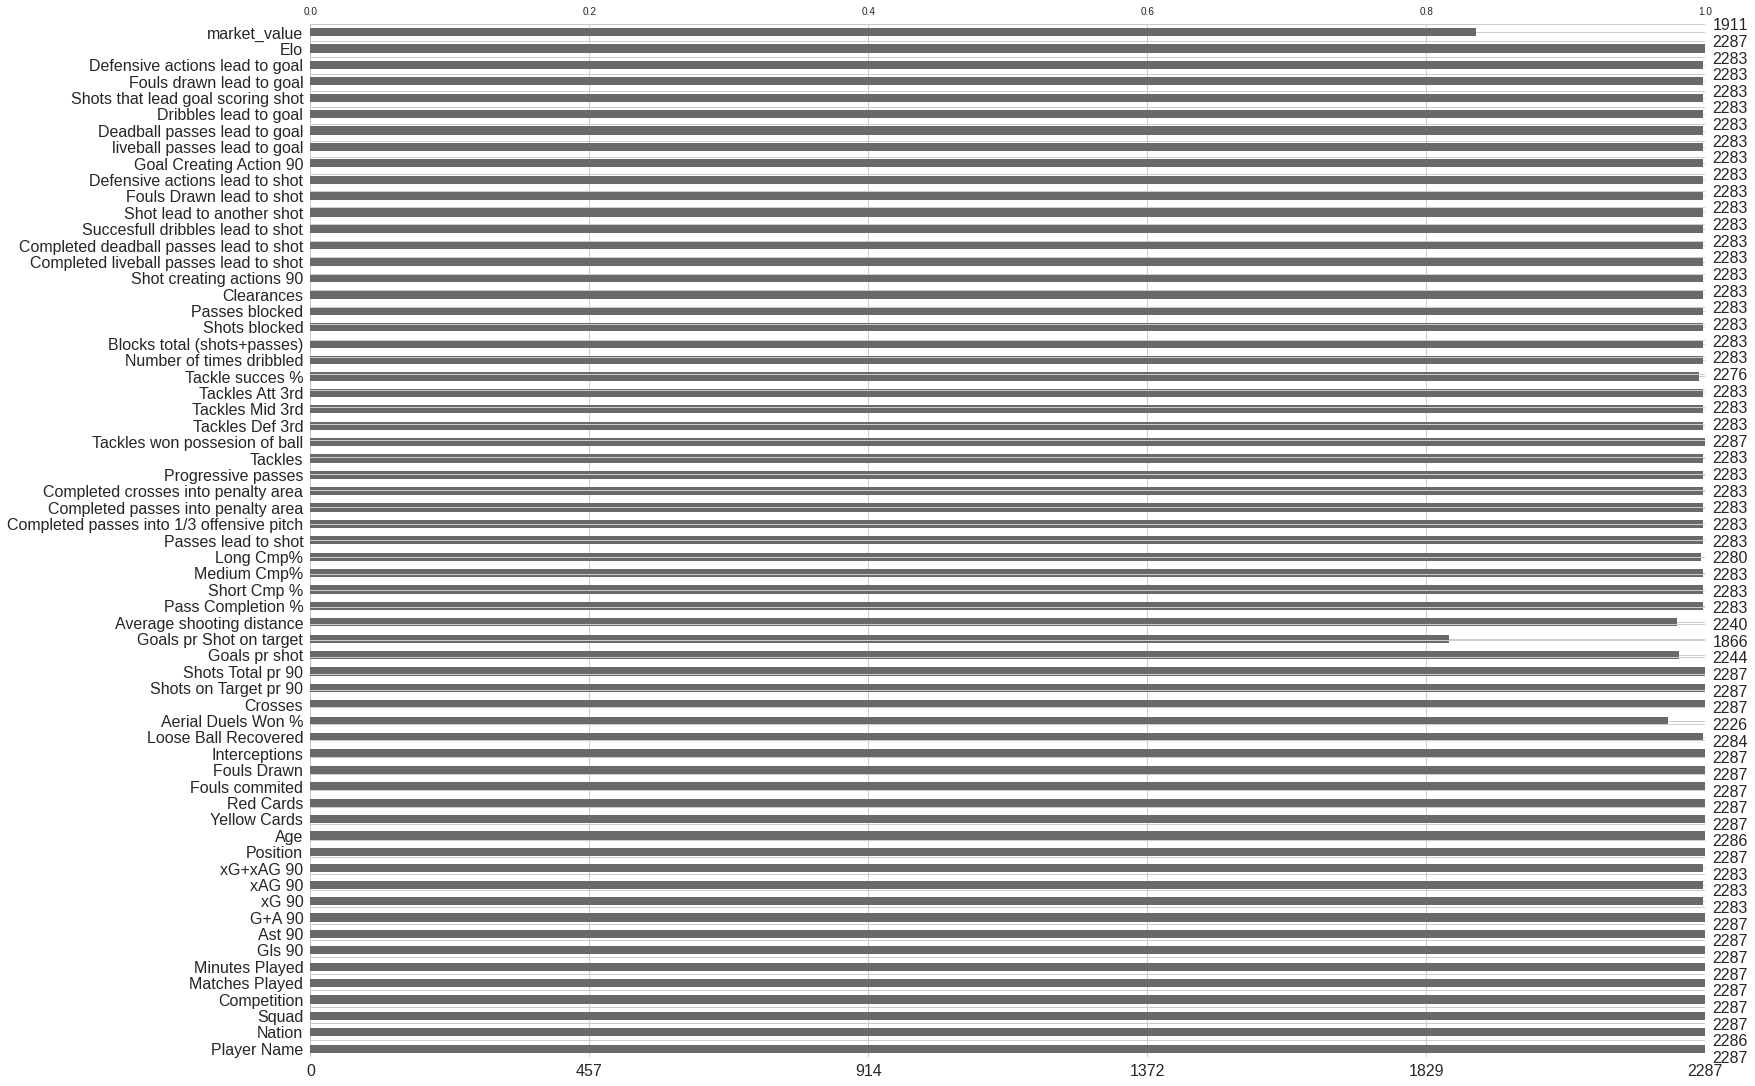

In [85]:
# Making some graphic to give a better overview
msno.bar(data)
# Goals pr shot on target has missing values if they do not have had any shots on target at all.

In [86]:
# After checking the variables, we checked the data and noticed that a blanc in this variable means that the player didnt have any shots on target
# therefore we set the NaN in Goals pr shot on target to 0
# further we drop thoose we dont have the target variable on
data["Goals pr Shot on target"] = data["Goals pr Shot on target"].fillna(0)
data = data[data['market_value'].notna()]


In [87]:
 data = data.dropna() ##TO BE REPLACED

### Correlation

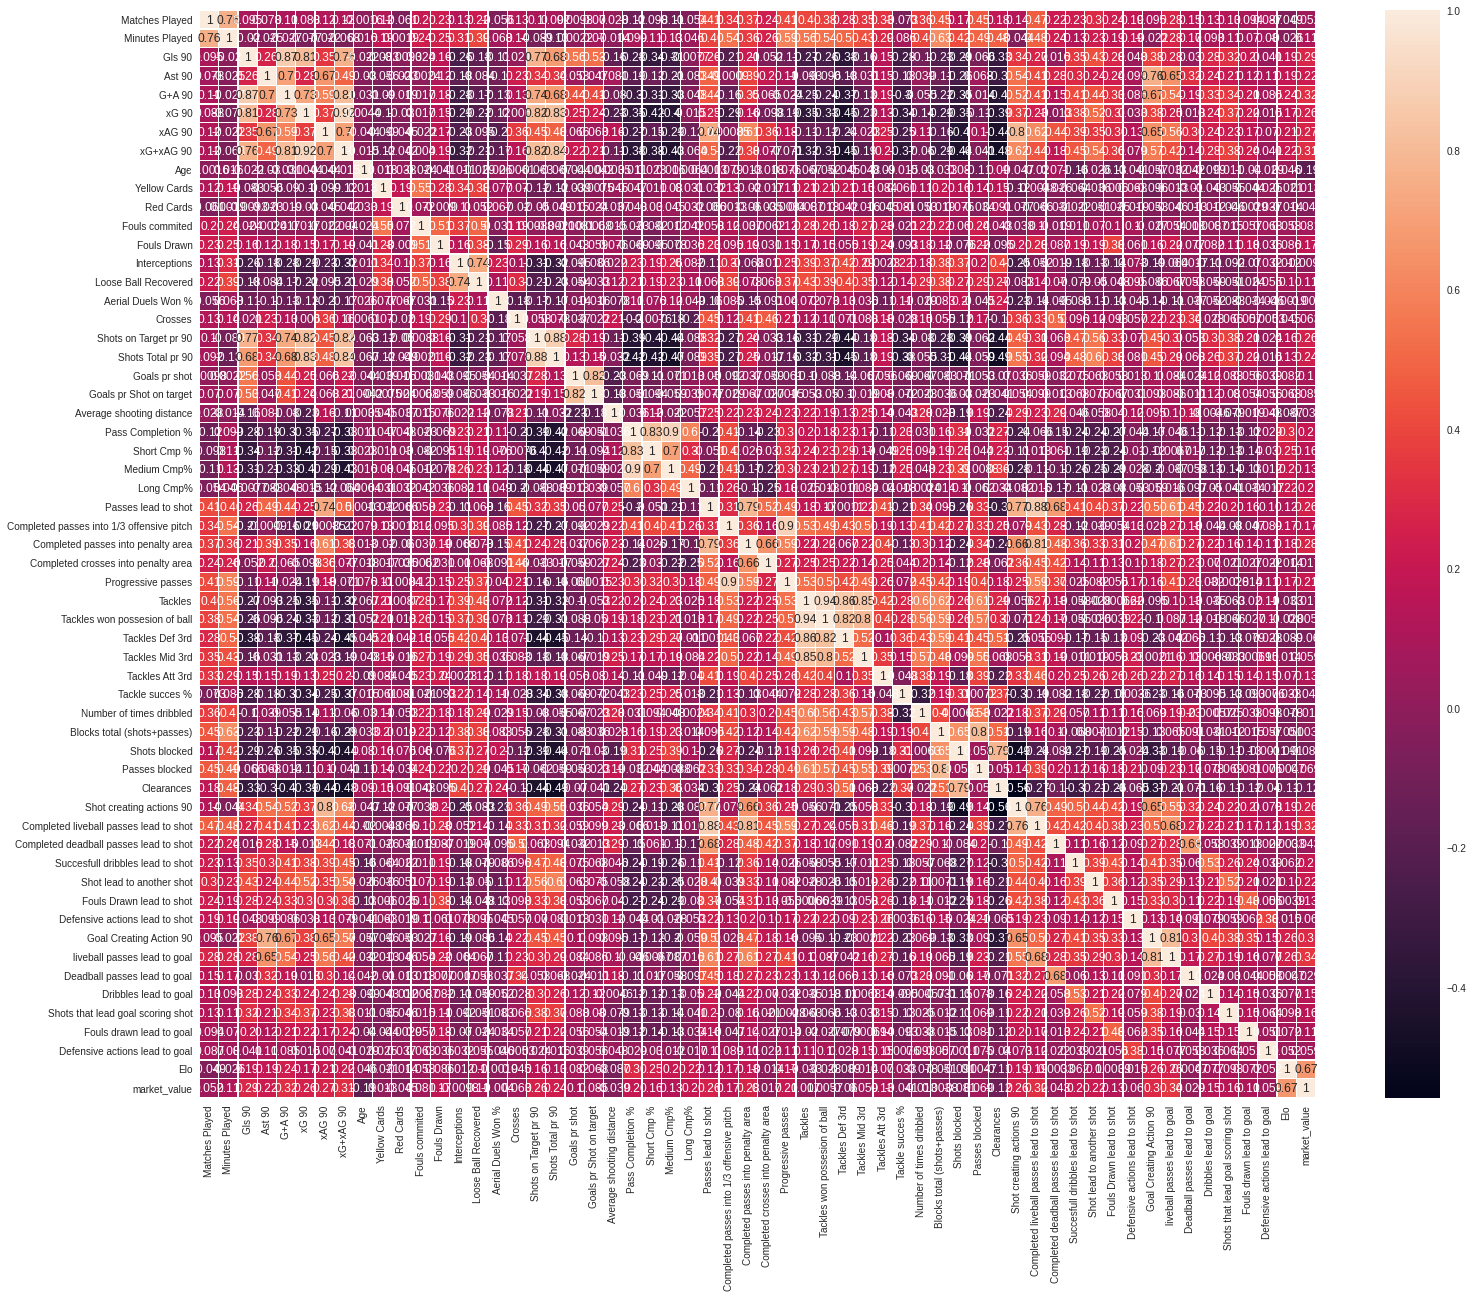

In [88]:
plt.figure(figsize=(25,20))
sns.heatmap(data.corr(),linewidths=.25, annot=True );
plt.yticks(rotation=360)
plt.show()

In [89]:
cor_matrix = data.corr().abs()
print(cor_matrix)

                                           Matches Played  Minutes Played  \
Matches Played                                   1.000000        0.757715   
Minutes Played                                   0.757715        1.000000   
Gls 90                                           0.094908        0.019521   
Ast 90                                           0.078288        0.024535   
G+A 90                                           0.110030        0.026614   
xG 90                                            0.088198        0.077242   
xAG 90                                           0.123593        0.021596   
xG+xAG 90                                        0.119678        0.067630   
Age                                              0.001591        0.015891   
Yellow Cards                                     0.124884        0.192998   
Red Cards                                        0.060543        0.001899   
Fouls commited                                   0.204858        0.242934   

In [90]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

                                           Matches Played  Minutes Played  \
Matches Played                                        NaN        0.757715   
Minutes Played                                        NaN             NaN   
Gls 90                                                NaN             NaN   
Ast 90                                                NaN             NaN   
G+A 90                                                NaN             NaN   
xG 90                                                 NaN             NaN   
xAG 90                                                NaN             NaN   
xG+xAG 90                                             NaN             NaN   
Age                                                   NaN             NaN   
Yellow Cards                                          NaN             NaN   
Red Cards                                             NaN             NaN   
Fouls commited                                        NaN             NaN   

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [91]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(); print(to_drop)


['xG+xAG 90', 'Medium Cmp%', 'Tackles won possesion of ball']


In [92]:
data = data.drop(['xG+xAG 90', 'Pass Completion %', 'Tackles won possesion of ball'], axis=1)

##Goalkeepers

In [93]:
dataGK = dataGK[dataGK["Minutes Played"]>360]

In [94]:
dataGK = dataGK[dataGK['market_value'].notna()]

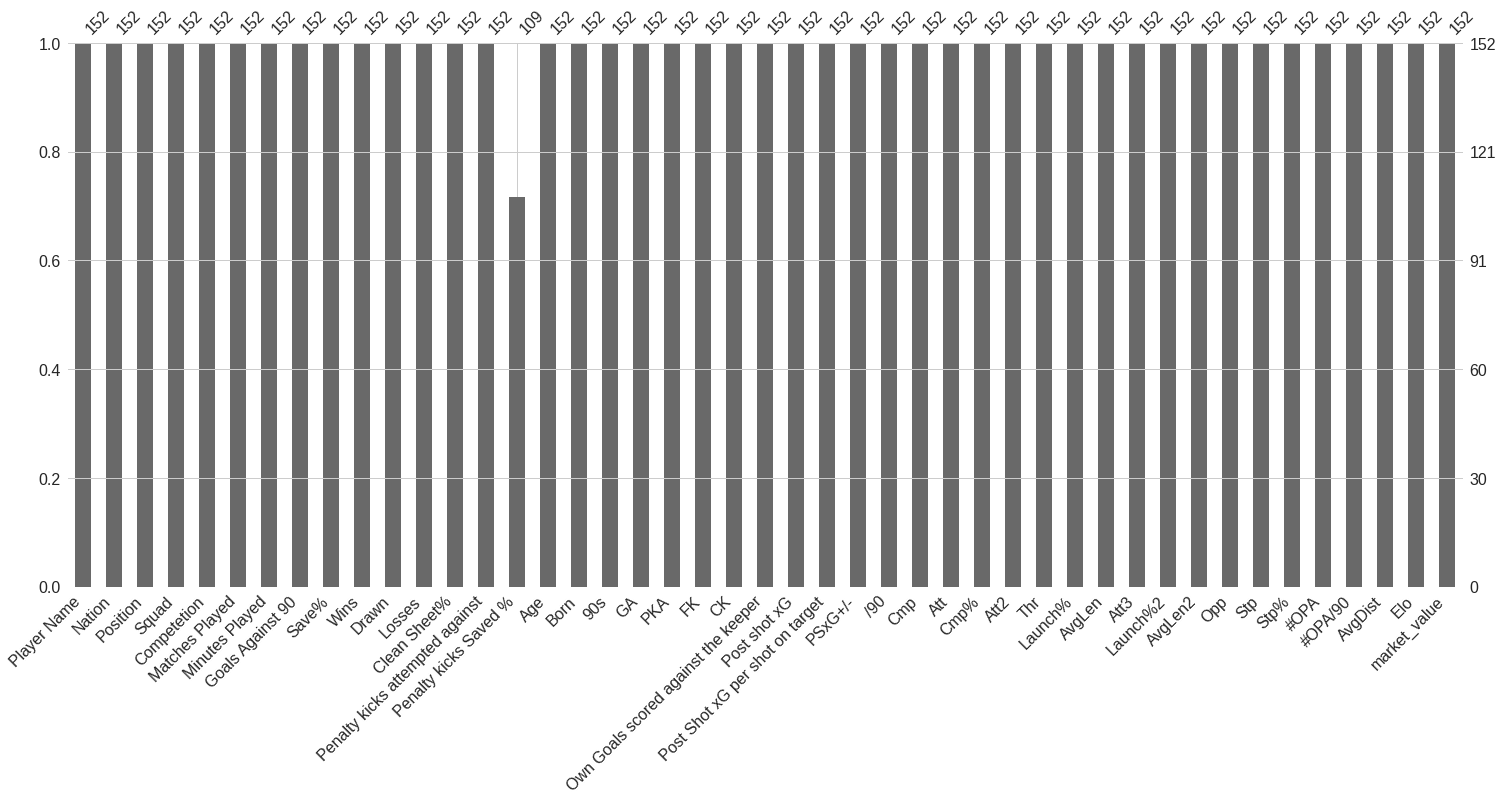

In [95]:
msno.bar(dataGK)

In [96]:
dataGK.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 1 to 240
Data columns (total 45 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Player Name                          152 non-null    object 
 1   Nation                               152 non-null    object 
 2   Position                             152 non-null    object 
 3   Squad                                152 non-null    object 
 4   Competetion                          152 non-null    object 
 5   Matches Played                       152 non-null    int64  
 6   Minutes Played                       152 non-null    int64  
 7   Goals Against 90                     152 non-null    float64
 8   Save%                                152 non-null    float64
 9   Wins                                 152 non-null    float64
 10  Drawn                                152 non-null    float64
 11  Losses                          

In [97]:
#Dropping features with many NaN. We also considered imputing, but choose to drop features since our football knowledge tells us that these are not important
dataGK = dataGK.drop(['Penalty kicks Saved %', 'Launch%2', 'Wins', 'Drawn', 'Losses', 'Born'], axis=1)

###Correlation

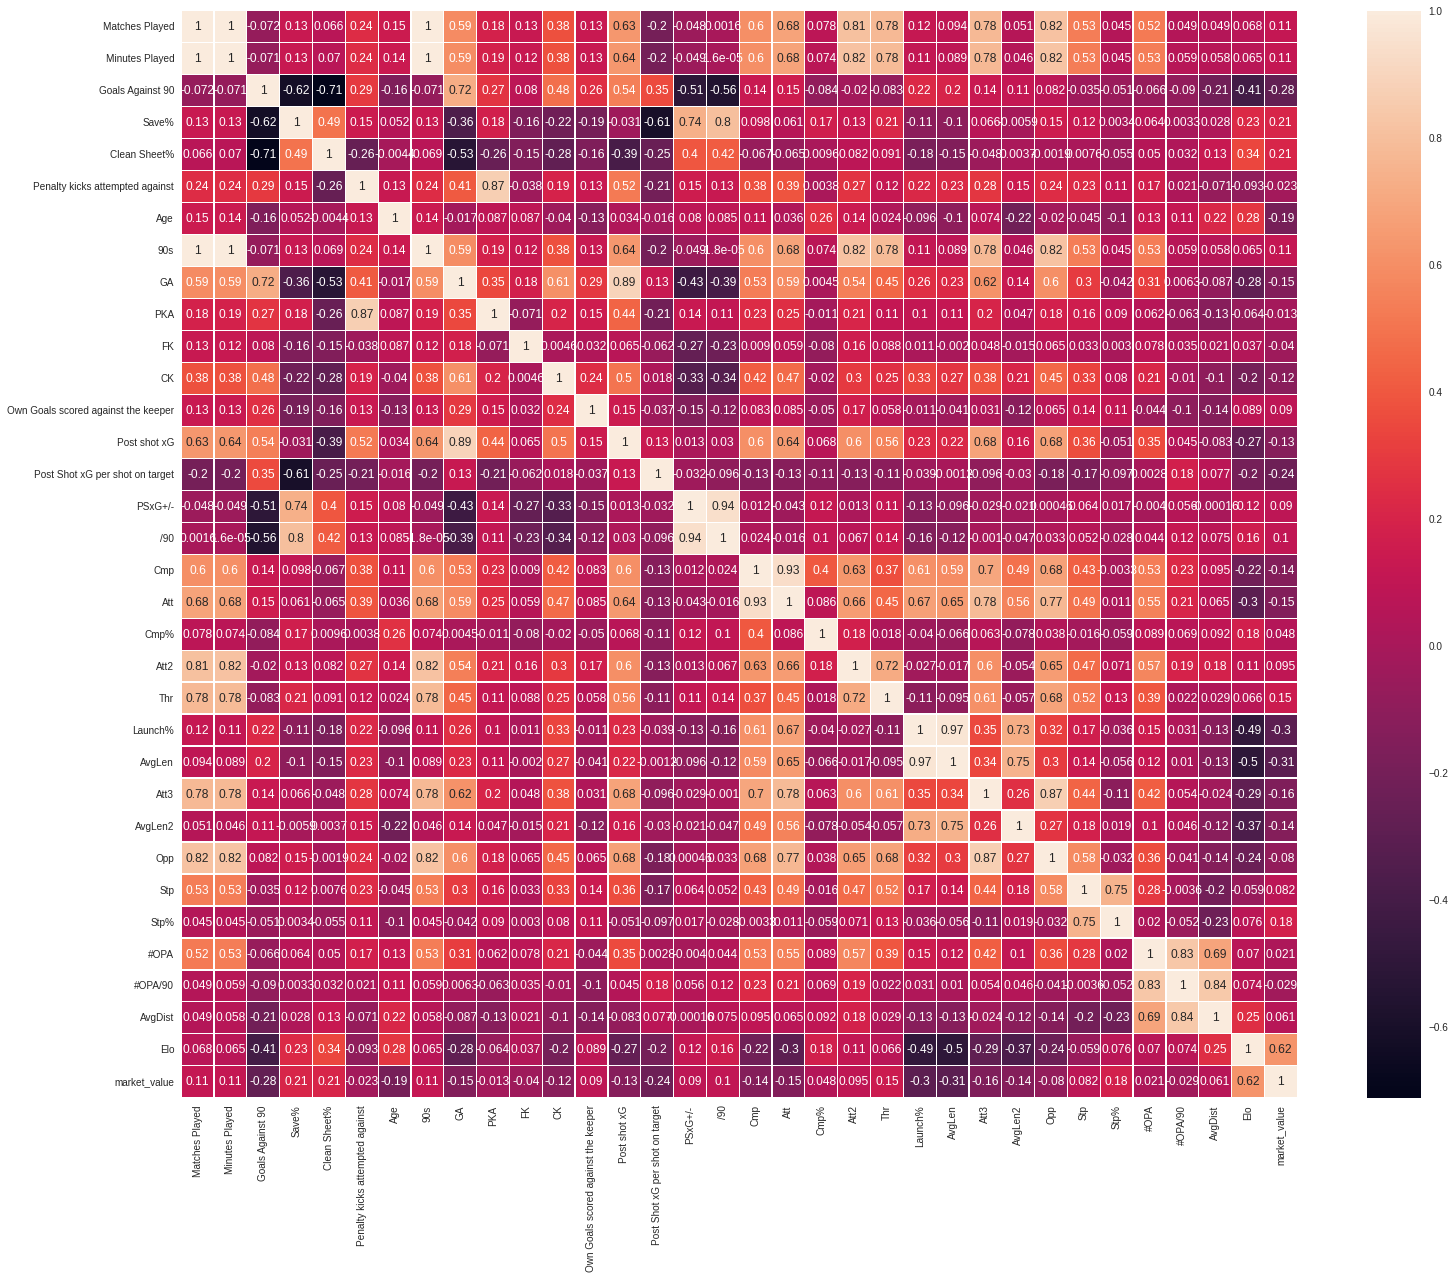

In [98]:
plt.figure(figsize=(25,20))
sns.heatmap(dataGK.corr(),linewidths=.25, annot=True );
plt.yticks(rotation=360)
plt.show()

In [99]:
cor_matrix_GK = dataGK.corr().abs()
print(cor_matrix_GK)

                                     Matches Played  Minutes Played  \
Matches Played                             1.000000        0.997779   
Minutes Played                             0.997779        1.000000   
Goals Against 90                           0.071978        0.071154   
Save%                                      0.131139        0.128949   
Clean Sheet%                               0.066411        0.069588   
Penalty kicks attempted against            0.241494        0.243253   
Age                                        0.150367        0.142049   
90s                                        0.997806        0.999996   
GA                                         0.591949        0.594671   
PKA                                        0.184971        0.188998   
FK                                         0.125748        0.124495   
CK                                         0.377884        0.375702   
Own Goals scored against the keeper        0.132903        0.125394   
Post s

In [100]:
upper_tri_GK = cor_matrix_GK.where(np.triu(np.ones(cor_matrix_GK.shape),k=1).astype(np.bool))

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [101]:
to_drop_GK = [column for column in upper_tri_GK.columns if any(upper_tri_GK[column] > 0.85)]
print(); print(to_drop_GK)


['Minutes Played', '90s', 'PKA', 'Post shot xG', '/90', 'Att', 'AvgLen', 'Opp']


In [102]:
#Dropping columns that have a high correlation
dataGK = dataGK.drop(['Matches Played', '90s', 'PKA', 'Post Shot xG per shot on target', '/90', 'Att', 'Att3', 'Cmp%', 'Thr', 'AvgLen', 'AvgLen2', 'Stp', 'AvgDist', '#OPA', 'Penalty kicks attempted against'], axis=1)

#EDA

In [103]:
data

Player Name   Nation         Squad         Competition  \
0      brenden aaronson   us USA  Leeds United  eng Premier League   
1      yunis abdelhamid   ma MAR         Reims          fr Ligue 1   
3     salis abdul samed   gh GHA          Lens          fr Ligue 1   
4       laurent abergel   fr FRA       Lorient          fr Ligue 1   
6     zakaria aboukhlal   ma MAR      Toulouse          fr Ligue 1   
...                 ...      ...           ...                 ...   
3605      rhys williams  eng ENG     Blackpool                 EFL   
3607      chris willock  eng ENG           QPR                 EFL   
3608         ben wilmot  eng ENG    Stoke City                 EFL   
3613       ben woodburn  wls WAL       Preston                 EFL   
3623       okay yokuslu   tr TUR     West Brom                 EFL   

      Matches Played  Minutes Played  Gls 90  Ast 90  G+A 90  xG 90  ...  \
0                 14            1189    0.08    0.15    0.23   0.14  ...   
1                 15            1350    0.00    0.00    0.00   0.09  ...   
3                 15            1349    0.07    0.00    0.07   0.02  ...   
4                 10             807    0.00    0.11    0.11   0.02  ...   
6                 15            1170    0.23    0.23    0.46   0.27  ...   
...              ...             ...     ...     ...     ...    ...  ...   
3605              14             960    0.00    0.00    0.00   0.03  ...   
3607              13             970    0.56    0.09    0.65   0.13  ...   
3608              21            1857    0.15    0.00    0.15   0.10  ...   
3613              18             555    0.00    0.32    0.32   0.15  ...   
3623              16            1037    0.09    0.00    0.09   0.13  ...   

      Defensive actions lead to shot Goal Creating Action 90  \
0                                1.0                    0.38   
1                                2.0                    0.13   
3                                1.0                    0.00   
4                                1.0                    0.11   
6                                0.0                    0.15   
...                              ...                     ...   
3605                             0.0                    0.00   
3607                             0.0                    0.74   
3608                             0.0                    0.05   
3613                             2.0                    0.49   
3623                             0.0                    0.17   

      liveball passes lead to goal  Deadball passes lead to goal  \
0                              3.0                           0.0   
1                              1.0                           0.0   
3                              0.0                           0.0   
4                              1.0                           0.0   
6                              1.0                           0.0   
...                            ...                           ...   
3605                           0.0                           0.0   
3607                           5.0                           0.0   
3608                           1.0                           0.0   
3613                           2.0                           0.0   
3623                           2.0                           0.0   

      Dribbles lead to goal  Shots that lead goal scoring shot  \
0                       0.0                                1.0   
1                       0.0                                1.0   
3                       0.0                                0.0   
4                       0.0                                0.0   
6                       1.0                                0.0   
...                     ...                                ...   
3605                    0.0                                0.0   
3607                    1.0                                2.0   
3608                    0.0                                0.0   
3613        

In [104]:
import seaborn

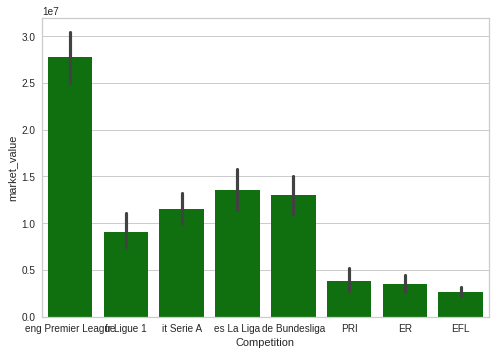

In [105]:
sns.barplot(x = 'Competition',y='market_value',data=data, color='green')

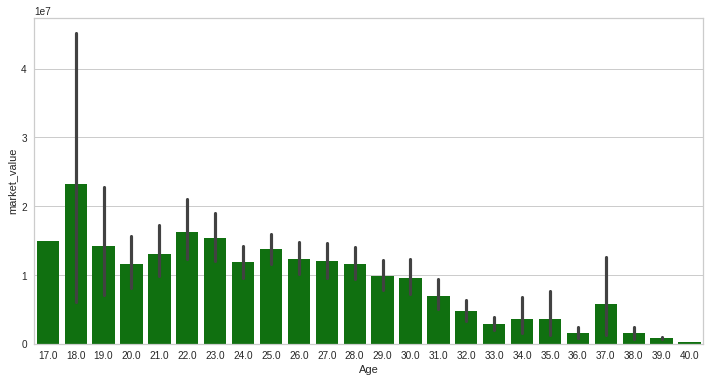

In [106]:
plt.figure(figsize=(12,6))
sns.barplot(x = 'Age',y='market_value',data=data, color='green')

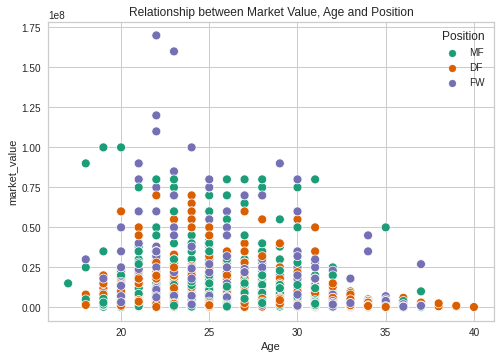

In [107]:
sns.scatterplot(x="Age", y="market_value", hue="Position", data=data, palette="Dark2", s=80)
plt.title("Relationship between Market Value, Age and Position")
plt.show()

In [108]:
data.filter(items=['Age','market_value']).describe().applymap('{:,.0f}'.format).T

count        mean         std      min        25%        50%  \
Age           1,824          26           4       17         23         26   
market_value  1,824  11,386,272  16,711,322  100,000  1,800,000  4,500,000   

                     75%          max  
Age                   29           40  
market_value  15,000,000  170,000,000

Preparing for SML we need to check for NaN

#Adjusting features according to Club Elo rating

##Fieldplayers

In [109]:
data = data.reset_index()

In [110]:
MinMaxScaler = MinMaxScaler()

In [111]:
Elo = MinMaxScaler.fit_transform(data.filter(items=['Elo']))

In [112]:
Elo = pd.DataFrame(Elo, columns=["Elo"])

In [113]:
data = data.drop(['Elo'], axis=1)

In [114]:
data = pd.concat([data, Elo], axis=1)

In [115]:
data.iloc[:,7:12] = data.iloc[:,7:12].multiply(data["Elo"], axis="index")
data.iloc[:,16:59] = data.iloc[:,16:59].multiply(data["Elo"], axis="index")

In [116]:
data = data.drop(['Elo'], axis=1)

##Goalkeepers

In [117]:
dataGK = dataGK.reset_index()

In [118]:
EloGK = MinMaxScaler.fit_transform(dataGK.filter(items=['Elo']))

In [119]:
EloGK = pd.DataFrame(EloGK, columns=["Elo"])

In [120]:
dataGK = dataGK.drop(['Elo'], axis=1)

In [121]:
dataGK = pd.concat([dataGK, EloGK], axis=1)

In [122]:
dataGK.iloc[:,8:11] = dataGK.iloc[:,8:11].multiply(dataGK["Elo"], axis="index")
dataGK.iloc[:,12:24] = dataGK.iloc[:,12:24].multiply(dataGK["Elo"], axis="index")

In [123]:
dataGK = dataGK.drop(['Elo'], axis=1)

# XGB

##Fieldplayers

In [124]:
#data = data.reset_index()

In [125]:
# Creating dummies with OneHotEncoding for the feature "Position"
ohe = OneHotEncoder(sparse=False)
ohe_X = ohe.fit_transform(data.filter(items=['Position', 'Competition']))
ohe_X =pd.DataFrame(ohe_X, columns =list(itertools.chain(*ohe.categories_)))

In [126]:
data = data.drop(['Position', 'Competition'], axis=1)
data = pd.concat([data, ohe_X], axis=1)

In [127]:
# Removing the leagues since we have adjusted features with elo ratings
data = data.drop(['EFL', 'ER', 'PRI', 'de Bundesliga', 'eng Premier League', 'es La Liga', 'fr Ligue 1', 'it Serie A'], axis=1)

In [238]:
data.to_excel('dataEDA.xlsx')

In [128]:
y = data[["market_value"]]

In [129]:
dataX = data.drop(['market_value', 'index'], axis=1)

In [130]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataX.iloc[:,3:56])

In [131]:
X_scaled = pd.DataFrame(X_scaled, columns=["Matches Played","Minutes Played","Gls 90","Ast 90",
                                           "G+A 90","xG 90","xAG 90","Age","Yellow Cards",
                                           "Red Cards","Fouls commited","Fouls Drawn","Interceptions","Loose Ball Recovered",
                                           "Aerial Duels Won %","Crosses","Shots on Target pr 90","Shots Total pr 90","Goals pr shot","Goals pr Shot on target",
                                           "Average shooting distance","Short Cmp %","Medium Cmp%","Long Cmp%","Passes lead to shot","Completed passes into 1/3 offensive pitch",
                                           "Completed passes into penalty area","Completed crosses into penalty area","Progressive passes","Tackles","Tackles Def 3rd",
                                           "Tackles Mid 3rd","Tackles Att 3rd","Tackle succes %","Number of times dribbled","Blocks total (shots+passes)","Shots blocked","Passes blocked","Clearances",
                                           "Shot creating actions 90","Completed liveball passes lead to shot","Completed deadball passes lead to shot","Succesfull dribbles lead to shot",
                                           "Shot lead to another shot","Fouls Drawn lead to shot","Defensive actions lead to shot","Goal Creating Action 90","liveball passes lead to goal",
                                           "Deadball passes lead to goal","Dribbles lead to goal","Shots that lead goal scoring shot","Fouls drawn lead to goal","Defensive actions lead to goal"])

In [132]:
dataX = pd.concat([dataX.iloc[:,:3], X_scaled, dataX.iloc[:,56:]], axis=1)

In [133]:
dataX.head(2)

Player Name  Nation         Squad  Matches Played  Minutes Played  \
0  brenden aaronson  us USA  Leeds United        0.610078        1.110625   
1  yunis abdelhamid  ma MAR         Reims        0.965599        1.648408   

     Gls 90    Ast 90    G+A 90     xG 90    xAG 90  ...  \
0 -0.220317  0.389931  0.027944  0.078336  1.248473  ...   
1 -0.572365 -0.598010 -0.683613 -0.348277 -0.687808  ...   

   Goal Creating Action 90  liveball passes lead to goal  \
0                 0.552767                      0.683367   
1                -0.435086                     -0.346020   

   Deadball passes lead to goal  Dribbles lead to goal  \
0                     -0.271623              -0.268182   
1                     -0.271623              -0.268182   

   Shots that lead goal scoring shot  Fouls drawn lead to goal  \
0                           1.532212                 -0.315297   
1                           0.951222                 -0.315297   

   Defensive actions lead to goal   DF   FW   MF  
0                        4.708708  0.0  0.0  1.0  
1                       -0.172825  1.0  0.0  0.0  

[2 rows x 59 columns]

In [134]:
#Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataX.iloc[:,3:], y, test_size = 0.2)

In [135]:
# Instanciating XGBRegressor
model_xgb = XGBRegressor(n_estimators=5000, learning_rate=0.005, max_depth=3, colsample_bytree=0.3)

In [136]:
# Fitting to train data
model_xgb.fit(X_train, y_train)

[12:01:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.3, learning_rate=0.005, n_estimators=5000)

In [137]:
print('Model XGB train score:' + ' ' + str(model_xgb.score(X_train, y_train)))
print('Model XGB test score :' + ' ' + str(model_xgb.score(X_test, y_test)))

Model XGB train score: 0.9558004386926885
Model XGB test score : 0.6570314924344469


In [138]:
#from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [139]:
# from sklearn.model_selection import cross_val_score

In [140]:
# xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

# scores = cross_val_score(xgb_model, dataX, y, scoring="neg_mean_squared_error", cv=5)

# display_scores(np.sqrt(-scores))

In [141]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [142]:
# scores = []
# for train_index, test_index in kfold.split(dataX):   
#     X_train, X_test = dataX[train_index], dataX[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     model_xgb.fit(X_train, y_train)
    
#     y_pred = model_xgb.predict(X_test)
    
#     scores.append(mean_squared_error(y_test, y_pred))
    
# display_scores(np.sqrt(scores))

## Hyper parameter tuning


This part is hashtagged because it takes ages to run

In [143]:
# from sklearn.model_selection import GridSearchCV
# params = { 'max_depth': [2, 3, 4, 5],
#            'learning_rate': [0.001, 0.005, 0.01],
#            'n_estimators': [1000, 2500, 5000, 7500],
#            'colsample_bytree': [0.1, 0.3, 0.5]}
# clf = GridSearchCV(estimator=model_xgb, 
#       param_grid=params,
#       scoring='neg_mean_squared_error', 
#       verbose=1)

In [144]:
# clf.fit(dataX.iloc[:,3:], y)
# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

This show the first run, which had a RMSE of 0,67. After this we ran it again with different paramter values and got a new optimal.

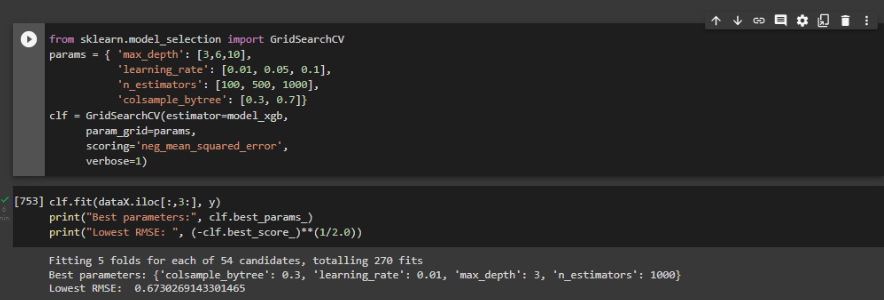

This show the second run, with changed parameter values and found a new optimal.

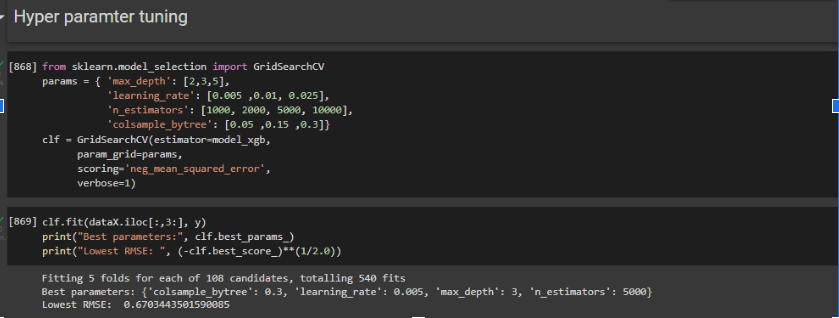

## Evaluation

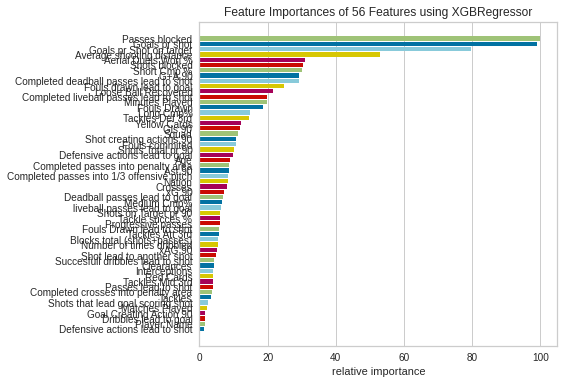

In [145]:
# Feature importance

viz = FeatureImportances(model_xgb)
viz.fit(dataX, y)
viz.show()

In [146]:
explainer = shap.TreeExplainer(model_xgb)

In [147]:
shap_values = explainer.shap_values(dataX.iloc[:,3:], check_additivity=False)

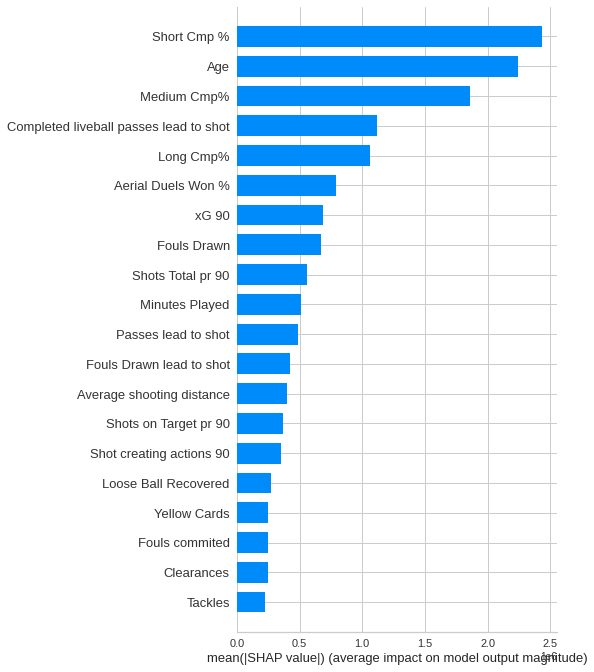

In [148]:
shap.summary_plot(shap_values, dataX.iloc[:,3:], plot_type="bar")

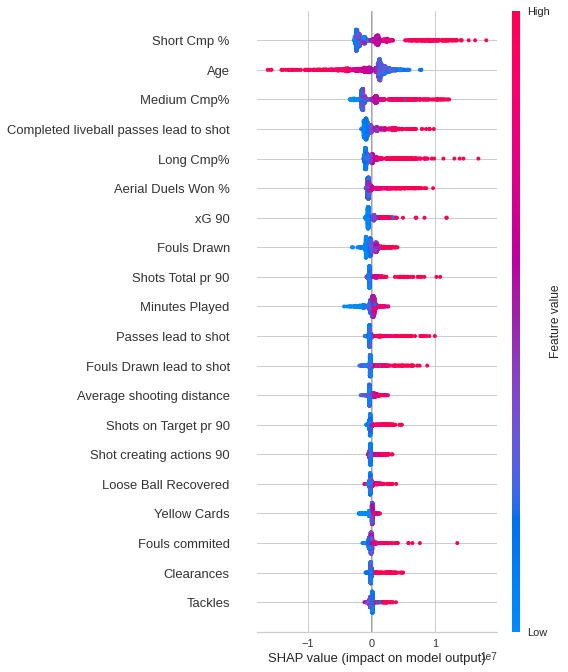

In [149]:
shap.summary_plot(shap_values, dataX.iloc[:,3:])

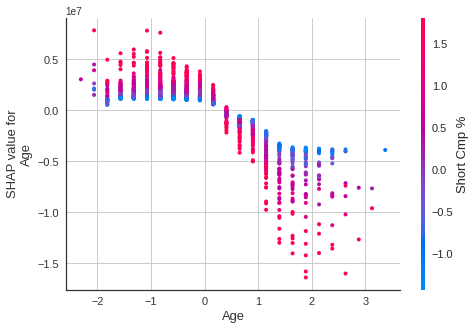

In [150]:
shap.dependence_plot("Age", shap_values, dataX.iloc[:,3:])

In [151]:
ExpID = 1024
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[ExpID], dataX.iloc[ExpID,3:])

###Differences

In [152]:
dataX['Prediction'] = model_xgb.predict(dataX.iloc[:,3:])/1000000

In [153]:
dataX['Prediction'] = dataX['Prediction'].round(2) 

In [154]:
predicted_data = pd.concat([dataX, y], axis=1)

In [155]:
predicted_data["market_value"] = predicted_data["market_value"]/1000000

In [156]:
predicted_data['difference'] = (predicted_data['Prediction']-predicted_data["market_value"]).round(2)

In [157]:
predicted_data["difference %"] = ((predicted_data['difference']/predicted_data["market_value"])*100).round(2)

In [158]:
#Top 20 positive difference 
predicted_data.sort_values('difference %',ascending=False).loc[:,['Player Name',"Minutes Played","Squad","DF","FW","MF", 'Prediction',"market_value", 'difference',"difference %"]].head(20)

Player Name  Minutes Played            Squad   DF   FW   MF  \
71                 arthur       -1.200841       Fiorentina  0.0  1.0  0.0   
1688          luke cundle       -0.709822     Swansea City  0.0  0.0  1.0   
1321              fabiano        0.355724            Braga  1.0  0.0  0.0   
1812              vitinho        1.625026          Burnley  1.0  0.0  0.0   
1768        iliman ndiaye        2.723974    Sheffield Utd  0.0  1.0  0.0   
1744   joel latibeaudiere        0.793299     Swansea City  1.0  0.0  0.0   
1752          ian maatsen        1.504776          Burnley  1.0  0.0  0.0   
1385                 pepe        0.893507            Porto  0.0  0.0  1.0   
1043               samuel        1.197472         Valencia  0.0  1.0  0.0   
1796       dion sanderson        3.151529  Birmingham City  1.0  0.0  0.0   
1355  juan manuel boselli       -1.080592   Gil Vicente FC  0.0  1.0  0.0   
1775         kenneth paal        2.810821              QPR  1.0  0.0  0.0   
1439           dirk abels       -1.281008     Sparta R'dam  1.0  0.0  0.0   
1083         thiago silva        0.726494          Chelsea  1.0  0.0  0.0   
1279             anderson       -0.195420          Vitória  0.0  1.0  0.0   
1765       carlton morris        2.129407       Luton Town  0.0  1.0  0.0   
1630  dario van den buijs        0.405828     RKC Waalwijk  1.0  0.0  0.0   
1381              patrick       -1.344473          Rio Ave  1.0  0.0  0.0   
1803            ben sheaf        2.416670    Coventry City  0.0  0.0  1.0   
1734           joao pedro        1.544860          Watford  0.0  0.0  1.0   

      Prediction  market_value  difference  difference %  
71          7.96         0.180        7.78       4322.22  
1688        4.25         0.180        4.07       2261.11  
1321        6.29         0.450        5.84       1297.78  
1812        7.33         0.600        6.73       1121.67  
1768        7.30         0.630        6.67       1058.73  
1744        5.15         0.450        4.70       1044.44  
1752        9.44         0.900        8.54        948.89  
1385        9.56         1.000        8.56        856.00  
1043       12.07         1.500       10.57        704.67  
1796        2.04         0.270        1.77        655.56  
1355        2.45         0.350        2.10        600.00  
1775        4.38         0.630        3.75        595.24  
1439        3.08         0.450        2.63        584.44  
1083       16.73         2.500       14.23        569.20  
1279        5.35         0.800        4.55        568.75  
1765        5.96         0.900        5.06        562.22  
1630        3.63         0.550        3.08        560.00  
1381        1.12         0.175        0.94        537.14  
1803        2.78         0.450        2.33        517.78  
1734        4.28         0.720        3.56        494.44

In [159]:
#Top 20 highest positive difference for "topplayers"
predicted_data[predicted_data['market_value']>20].sort_values('difference %',ascending=False).loc[:,['Player Name',"Minutes Played","Squad","DF","FW","MF", 'Prediction',"market_value", 'difference',"difference %"]].head(20)

Player Name  Minutes Played            Squad   DF   FW   MF  \
911       benjamin pavard        0.536098    Bayern Munich  1.0  0.0  0.0   
461             joe gomez        0.101864        Liverpool  1.0  0.0  0.0   
132         karim benzema       -0.766606      Real Madrid  0.0  1.0  0.0   
738        tyrell malacia       -0.967022   Manchester Utd  1.0  0.0  0.0   
498        ilkay gundogan        0.115225  Manchester City  0.0  0.0  1.0   
708    ruben loftus cheek        0.325662          Chelsea  0.0  0.0  1.0   
1120          john stones       -0.419218  Manchester City  1.0  0.0  0.0   
719        hirving lozano       -0.462642           Napoli  0.0  1.0  0.0   
1192      dayot upamecano        1.615005    Bayern Munich  1.0  0.0  0.0   
851       tanguy ndombele       -1.294369           Napoli  0.0  0.0  1.0   
726   alexis mac allister        1.334423         Brighton  0.0  0.0  1.0   
1371          david neres       -0.342392          Benfica  0.0  1.0  0.0   
866          darwin nunez       -0.843432        Liverpool  0.0  1.0  0.0   
1064       xaver schlager       -0.095212       RB Leipzig  0.0  0.0  1.0   
978            david raum        0.592883       RB Leipzig  1.0  0.0  0.0   
1174        ferran torres       -0.960342        Barcelona  0.0  1.0  0.0   
976     giacomo raspadori       -1.144057           Napoli  0.0  1.0  0.0   
775     noussair mazraoui       -1.003765    Bayern Munich  1.0  0.0  0.0   
1250         granit xhaka        1.033798          Arsenal  0.0  0.0  1.0   
1462      steven bergwijn        0.699772             Ajax  0.0  1.0  0.0   

      Prediction  market_value  difference  difference %  
911        70.32          35.0       35.32        100.91  
461        59.63          30.0       29.63         98.77  
132        53.48          35.0       18.48         52.80  
738        33.00          22.0       11.00         50.00  
498        36.77          25.0       11.77         47.08  
708        36.58          25.0       11.58         46.32  
1120       41.91          30.0       11.91         39.70  
719        38.23          28.0       10.23         36.54  
1192       67.57          50.0       17.57         35.14  
851        37.46          28.0        9.46         33.79  
726        42.00          32.0       10.00         31.25  
1371       28.47          22.0        6.47         29.41  
866        87.92          70.0       17.92         25.60  
1064       26.89          22.0        4.89         22.23  
978        31.67          26.0        5.67         21.81  
1174       41.71          35.0        6.71         19.17  
976        41.59          35.0        6.59         18.83  
775        29.47          25.0        4.47         17.88  
1250       32.19          28.0        4.19         14.96  
1462       30.56          27.0        3.56         13.19

In [160]:
#Top 20 negative difference 
predicted_data.sort_values('difference %',ascending=True).loc[:,['Player Name',"Minutes Played","Squad","DF","FW","MF", 'Prediction',"market_value", 'difference',"difference %"]].head(20)

Player Name  Minutes Played           Squad   DF   FW   MF  \
1334        vitor gomes       -1.357834         Rio Ave  0.0  0.0  1.0   
1422         pedro tiba       -1.250945  Gil Vicente FC  0.0  0.0  1.0   
1303  anderson carvalho       -1.257626     Santa Clara  0.0  0.0  1.0   
1329     nicolas gaitan       -1.414618           Paços  0.0  0.0  1.0   
1633    jeroen veldmate        0.736515           Emmen  1.0  0.0  0.0   
266   mathieu coutadeur       -0.182059         Ajaccio  0.0  0.0  1.0   
1324    ruben fernandes        0.449251  Gil Vicente FC  1.0  0.0  0.0   
482     christian gross        0.155308   Werder Bremen  0.0  0.0  1.0   
1284   vitorino antunes        0.806660           Paços  1.0  0.0  0.0   
1563      robert muhren        0.512717        Volendam  0.0  1.0  0.0   
1728     junior hoilett        2.496836         Reading  1.0  0.0  0.0   
1735    stefan johansen        0.870125             QPR  0.0  0.0  1.0   
1780        lee peltier        0.592883   Rotherham Utd  1.0  0.0  0.0   
39     mickael alphonse       -0.683100         Ajaccio  1.0  0.0  0.0   
1663        joe bennett       -1.427979  Wigan Athletic  1.0  0.0  0.0   
1426    fernando varela       -1.087272        Casa Pia  1.0  0.0  0.0   
1767      kyle naughton        1.331082    Swansea City  1.0  0.0  0.0   
590               josan       -1.551569           Elche  1.0  0.0  0.0   
1683         sam clucas       -1.351153      Stoke City  0.0  0.0  1.0   
1718        dan gosling        0.091843         Watford  1.0  0.0  0.0   

      Prediction  market_value  difference  difference %  
1334       -0.93          0.10       -1.03      -1030.00  
1422       -0.84          0.30       -1.14       -380.00  
1303       -0.86          0.40       -1.26       -315.00  
1329       -0.54          0.30       -0.84       -280.00  
1633       -0.58          0.35       -0.93       -265.71  
266        -0.40          0.25       -0.65       -260.00  
1324       -0.13          0.10       -0.23       -230.00  
482        -0.60          0.50       -1.10       -220.00  
1284       -0.23          0.20       -0.43       -215.00  
1563       -0.67          0.60       -1.27       -211.67  
1728       -0.61          0.72       -1.33       -184.72  
1735       -0.99          1.35       -2.34       -173.33  
1780       -0.19          0.27       -0.46       -170.37  
39         -0.21          0.30       -0.51       -170.00  
1663       -0.86          1.35       -2.21       -163.70  
1426       -0.17          0.30       -0.47       -156.67  
1767       -0.40          0.72       -1.12       -155.56  
590        -0.44          1.00       -1.44       -144.00  
1683       -0.58          1.35       -1.93       -142.96  
1718       -0.21          0.90       -1.11       -123.33

In [161]:
#Top 20 highest negative difference for "topplayers"
predicted_data[predicted_data['market_value']>20].sort_values('difference %',ascending=True).loc[:,['Player Name',"Minutes Played","Squad","DF","FW","MF", 'Prediction',"market_value", 'difference',"difference %"]].head(20)

Player Name  Minutes Played            Squad   DF   FW   MF  \
1227   james ward prowse        1.648408      Southampton  0.0  0.0  1.0   
133     domenico berardi       -1.578292         Sassuolo  0.0  1.0  0.0   
915                pedri        0.562821        Barcelona  0.0  0.0  1.0   
200       mohamed camara       -1.605014             Roma  0.0  0.0  1.0   
1226  kyle walker peters        0.318981      Southampton  1.0  0.0  0.0   
865        matheus nunes        0.001655           Wolves  0.0  0.0  1.0   
401      bruno fernandes        1.043819   Manchester Utd  0.0  0.0  1.0   
812      tyrick mitchell        0.402488   Crystal Palace  1.0  0.0  0.0   
855          ruben neves        1.347784           Wolves  0.0  0.0  1.0   
450   morgan gibbs white        0.599564  Nott'ham Forest  0.0  1.0  0.0   
123      jude bellingham        1.648408         Dortmund  0.0  0.0  1.0   
1283              antony       -0.599593           Arouca  0.0  0.0  1.0   
1263      nicolo zaniolo       -0.298969             Roma  0.0  0.0  1.0   
646        mateo kovacic       -0.739884          Chelsea  0.0  0.0  1.0   
28           david alaba        1.030458      Real Madrid  1.0  0.0  0.0   
1238      inaki williams        0.946952    Athletic Club  0.0  1.0  0.0   
644         jules kounde       -0.950321        Barcelona  1.0  0.0  0.0   
488       goncalo guedes       -0.559510           Wolves  0.0  1.0  0.0   
21       rayan ait nouri       -0.636336           Wolves  1.0  0.0  0.0   
1052        jadon sancho       -0.476003   Manchester Utd  0.0  1.0  0.0   

      Prediction  market_value  difference  difference %  
1227        9.08          35.0      -25.92        -74.06  
133         8.34          23.0      -14.66        -63.74  
915        39.84         100.0      -60.16        -60.16  
200        10.55          25.0      -14.45        -57.80  
1226       10.97          25.0      -14.03        -56.12  
865        20.02          45.0      -24.98        -55.51  
401        34.42          75.0      -40.58        -54.11  
812        13.11          28.0      -14.89        -53.18  
855        18.79          40.0      -21.21        -53.02  
450        12.07          25.0      -12.93        -51.72  
123        48.52         100.0      -51.48        -51.48  
1283       37.16          75.0      -37.84        -50.45  
1263       14.88          30.0      -15.12        -50.40  
646        19.91          40.0      -20.09        -50.22  
28         28.25          55.0      -26.75        -48.64  
1238       12.91          25.0      -12.09        -48.36  
644        31.16          60.0      -28.84        -48.07  
488        16.64          32.0      -15.36        -48.00  
21         11.55          22.0      -10.45        -47.50  
1052       32.14          60.0      -27.86        -46.43

In [162]:
data.filter(items=['Gls 90','Ast 90']).describe().applymap('{:,.2f}'.format).T

count  mean   std   min   25%   50%   75%   max
Gls 90  1,824.00  0.07  0.12  0.00  0.00  0.02  0.09  1.56
Ast 90  1,824.00  0.05  0.08  0.00  0.00  0.00  0.07  0.72

In [163]:
data['Squad'].value_counts()

Köln             16
Dortmund         16
Hellas Verona    16
Elche            16
Milan            16
                 ..
Coventry City     5
Cardiff City      4
Huddersfield      3
Rotherham Utd     3
Blackburn         2
Name: Squad, Length: 158, dtype: int64

#LinearRegression

In [164]:
model_lr = LinearRegression()

In [165]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [166]:
print('Model LinearRegression train score:' + ' ' + str(model_lr.score(X_train, y_train)))
print('Model LinearRegression test score :' + ' ' + str(model_lr.score(X_test, y_test)))

Model LinearRegression train score: 0.652201331828871
Model LinearRegression test score : 0.5932853651138812


#RandomForest

In [167]:
model_rf = RandomForestRegressor()

In [168]:
model_rf.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor()

In [169]:
print('Model RandomForest train score:' + ' ' + str(model_rf.score(X_train, y_train)))
print('Model RandomForest test score :' + ' ' + str(model_rf.score(X_test, y_test)))

Model RandomForest train score: 0.9538489582068753
Model RandomForest test score : 0.6569326178587894


#FOR EACH POSITION


##Defender

In [170]:
data_DF = data[data['DF'] == 1.0]

In [171]:
y_DF = data_DF[["market_value"]]

In [172]:
data_DF = data_DF.drop(['market_value'], axis=1)

In [173]:
scaler_DF = StandardScaler()
X_scaled_DF = scaler_DF.fit_transform(data_DF.iloc[:,4:57])

In [174]:
X_scaled_DF = pd.DataFrame(X_scaled_DF, columns=["Matches Played","Minutes Played","Gls 90","Ast 90","G+A 90","xG 90","xAG 90",
                                                 "Age","Yellow Cards","Red Cards","Fouls commited","Fouls Drawn","Interceptions","Loose Ball Recovered",
                                                 "Aerial Duels Won %","Crosses","Shots on Target pr 90","Shots Total pr 90","Goals pr shot","Goals pr Shot on target",
                                                 "Average shooting distance","Short Cmp %","Medium Cmp%","Long Cmp%","Passes lead to shot","Completed passes into 1/3 offensive pitch",
                                                 "Completed passes into penalty area","Completed crosses into penalty area","Progressive passes","Tackles","Tackles Def 3rd",
                                                 "Tackles Mid 3rd","Tackles Att 3rd","Tackle succes %","Number of times dribbled","Blocks total (shots+passes)","Shots blocked","Passes blocked","Clearances",
                                                 "Shot creating actions 90","Completed liveball passes lead to shot","Completed deadball passes lead to shot","Succesfull dribbles lead to shot",
                                                 "Shot lead to another shot","Fouls Drawn lead to shot","Defensive actions lead to shot","Goal Creating Action 90","liveball passes lead to goal",
                                                 "Deadball passes lead to goal","Dribbles lead to goal","Shots that lead goal scoring shot","Fouls drawn lead to goal","Defensive actions lead to goal"])

In [175]:
data_DF = data_DF.reset_index()

In [176]:
data_DF = pd.concat([data_DF.iloc[:,2:5], X_scaled_DF, data_DF.iloc[:,58:]], axis=1)

In [177]:
# selecting relevant features, dropping irrelevant features based on intuition
data_DF = data_DF.drop(["Player Name","Nation","Squad",'DF','MF','FW',"Matches Played","G+A 90",
                        "Fouls Drawn", "Shots on Target pr 90", "Shots Total pr 90", 
                        "Goals pr shot", "Goals pr Shot on target", "Average shooting distance",
                        "Completed passes into 1/3 offensive pitch","Passes lead to shot",
                        "Short Cmp %", "Medium Cmp%","Long Cmp%","Completed passes into penalty area", "Completed crosses into penalty area", 
                        "Tackles Att 3rd","Tackles Def 3rd","Tackles Mid 3rd", "Tackles", 
                        "Shot creating actions 90", "Completed liveball passes lead to shot",  
                        "Completed deadball passes lead to shot", "Succesfull dribbles lead to shot", "Shot lead to another shot",
                        "Fouls Drawn lead to shot","Fouls drawn lead to goal",
                        "Goal Creating Action 90", "liveball passes lead to goal", "Deadball passes lead to goal",
                        "Dribbles lead to goal", "Shots that lead goal scoring shot", "Fouls drawn lead to goal"], 
                       axis=1)


In [178]:
#Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_DF, y_DF, test_size = 0.2)

In [179]:
# Instanciating XGBRegressor
model_xgb_DF = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3, colsample_bytree=0.3)

In [180]:
# Fitting to train data
model_xgb_DF.fit(X_train, y_train)

[12:01:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.3, learning_rate=0.05, n_estimators=1000)

In [181]:
print('Model XGB for defenders train score:' + ' ' + str(model_xgb_DF.score(X_train, y_train)))
print('Model XGB for defenders test score :' + ' ' + str(model_xgb_DF.score(X_test, y_test)))

Model XGB for defenders train score: 0.9946287676202984
Model XGB for defenders test score : 0.6092142428268352


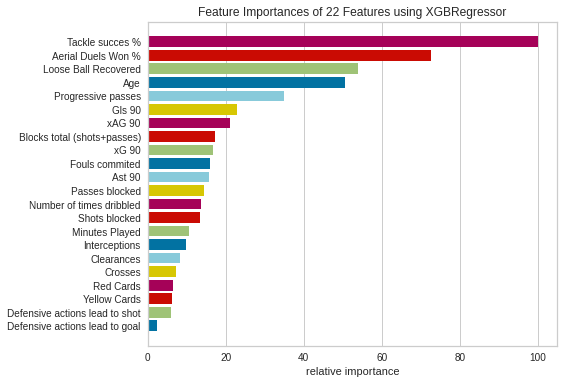

In [182]:
# Feature importance

viz = FeatureImportances(model_xgb_DF)
viz.fit(data_DF, y_DF)
viz.show()

In [183]:
explainer_DF = shap.TreeExplainer(model_xgb_DF)

In [184]:
shap_values_DF = explainer_DF.shap_values(data_DF)

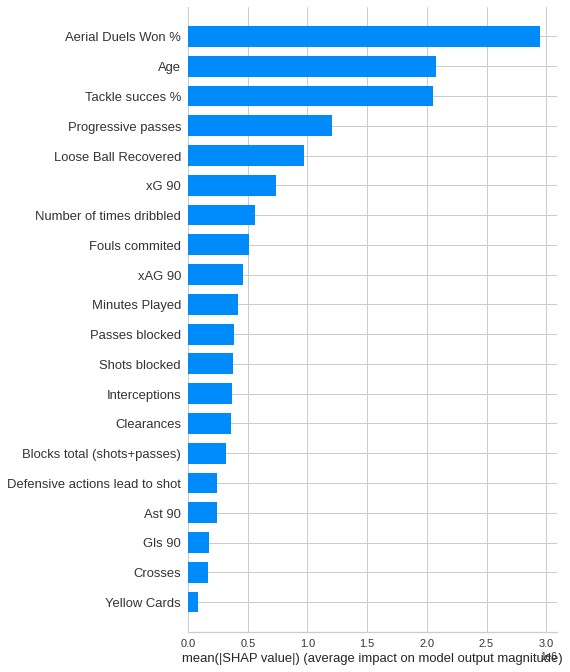

In [185]:
shap.summary_plot(shap_values_DF, data_DF, plot_type="bar")

##Midfielder

In [186]:
data_MF = data[data['MF'] == 1.0]

In [187]:
y_MF = data_MF[["market_value"]]

In [188]:
data_MF = data_MF.drop(['market_value'], axis=1)

In [189]:
scaler_MF = StandardScaler()
X_scaled_MF = scaler_MF.fit_transform(data_MF.iloc[:,4:57])

In [190]:
X_scaled_MF = pd.DataFrame(X_scaled_MF, columns=["Matches Played","Minutes Played","Gls 90","Ast 90",
                                                 "G+A 90","xG 90","xAG 90","Age","Yellow Cards",
                                                 "Red Cards","Fouls commited","Fouls Drawn","Interceptions",
                                                 "Loose Ball Recovered","Aerial Duels Won %","Crosses",
                                                 "Shots on Target pr 90","Shots Total pr 90","Goals pr shot",
                                                 "Goals pr Shot on target","Average shooting distance",
                                                 "Short Cmp %","Medium Cmp%","Long Cmp%","Passes lead to shot","Completed passes into 1/3 offensive pitch",
                                                 "Completed passes into penalty area","Completed crosses into penalty area","Progressive passes","Tackles",
                                                 "Tackles Def 3rd","Tackles Mid 3rd","Tackles Att 3rd","Tackle succes %",
                                                 "Number of times dribbled","Blocks total (shots+passes)","Shots blocked","Passes blocked","Clearances",
                                                 "Shot creating actions 90","Completed liveball passes lead to shot","Completed deadball passes lead to shot",
                                                 "Succesfull dribbles lead to shot","Shot lead to another shot","Fouls Drawn lead to shot","Defensive actions lead to shot",
                                                 "Goal Creating Action 90","liveball passes lead to goal","Deadball passes lead to goal","Dribbles lead to goal","Shots that lead goal scoring shot",
                                                 "Fouls drawn lead to goal","Defensive actions lead to goal"])

In [191]:
data_MF = data_MF.reset_index()

In [192]:
data_MF = pd.concat([data_MF.iloc[:,2:5], X_scaled_MF, data_MF.iloc[:,58:]], axis=1)

In [193]:
# selecting relevant features, dropping irrelevant features based on intuition
data_MF = data_MF.drop(["Player Name","Nation","Squad",'DF','MF','FW',"Matches Played","G+A 90",
                        "Yellow Cards","Red Cards","Short Cmp %","Medium Cmp%","Long Cmp%",
                        "Tackles Att 3rd","Tackles Def 3rd","Tackles Mid 3rd",
                        "Tackles Att 3rd","Tackle succes %", "Number of times dribbled", "Shot creating actions 90",
                        "Blocks total (shots+passes)", "Shots blocked","Passes blocked","Clearances",
                        "Fouls Drawn lead to shot","Fouls drawn lead to goal", "liveball passes lead to goal",
                        "Deadball passes lead to goal", "Dribbles lead to goal",
                        "Defensive actions lead to shot","Defensive actions lead to goal"], 
                       axis=1)


In [194]:
#Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_MF, y_MF, test_size = 0.2)

In [195]:
# Instanciating XGBRegressor
model_xgb_MF = XGBRegressor()

In [196]:
# Fitting to train data
model_xgb_MF.fit(X_train, y_train)

[12:01:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [197]:
print('Model XGB for midfielders train score:' + ' ' + str(model_xgb_MF.score(X_train, y_train)))
print('Model XGB for midfielders test score :' + ' ' + str(model_xgb_MF.score(X_test, y_test)))

Model XGB for midfielders train score: 0.967440930084882
Model XGB for midfielders test score : 0.4772466966797074


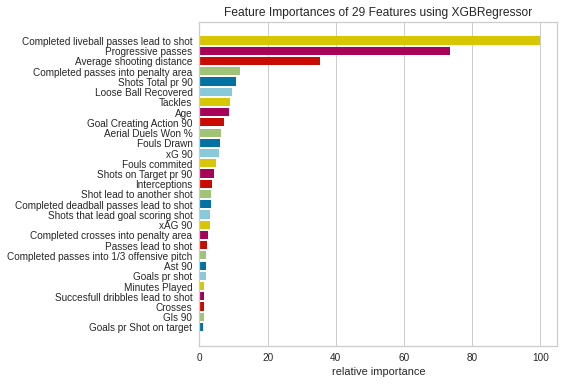

In [198]:
# Feature importance

viz = FeatureImportances(model_xgb_MF)
viz.fit(data_MF, y_MF)
viz.show()

In [199]:
explainer_MF = shap.TreeExplainer(model_xgb_MF)

In [200]:
shap_values_MF = explainer_MF.shap_values(data_MF)

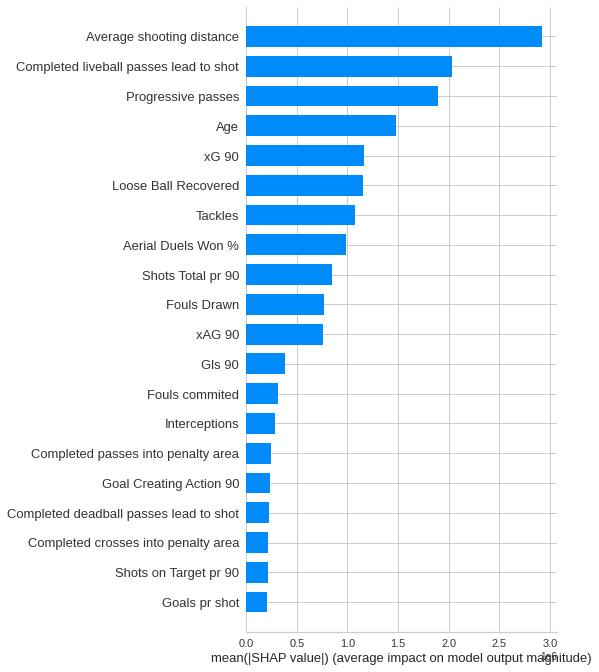

In [201]:
shap.summary_plot(shap_values_MF, data_MF, plot_type="bar")

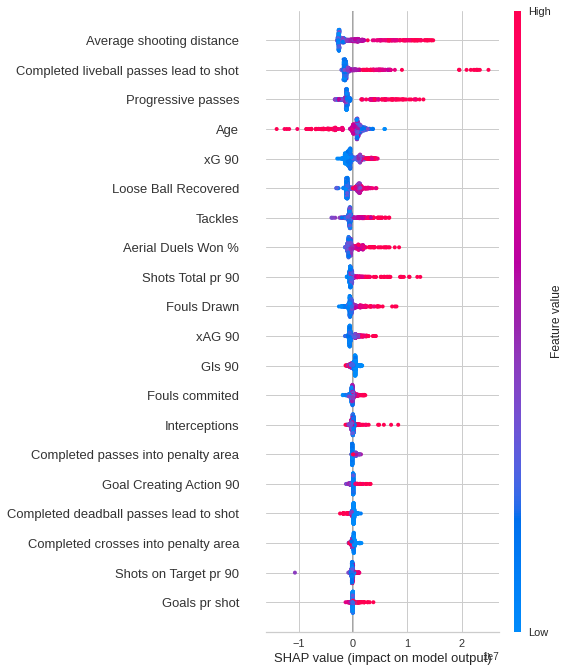

In [202]:
shap.summary_plot(shap_values_MF, data_MF)

##Forward

In [203]:
data_FW = data[data['FW'] == 1.0]

In [204]:
y_FW = data_FW[["market_value"]]

In [205]:
data_FW = data_FW.drop(['market_value'], axis=1)

In [206]:
scaler_FW = StandardScaler()
X_scaled_FW = scaler_FW.fit_transform(data_FW.iloc[:,4:57])

In [207]:
X_scaled_FW = pd.DataFrame(X_scaled_FW, columns=["Matches Played","Minutes Played","Gls 90","Ast 90","G+A 90","xG 90","xAG 90","Age","Yellow Cards","Red Cards",
                                                 "Fouls commited","Fouls Drawn","Interceptions","Loose Ball Recovered","Aerial Duels Won %","Crosses","Shots on Target pr 90",
                                                 "Shots Total pr 90","Goals pr shot","Goals pr Shot on target","Average shooting distance","Short Cmp %",
                                                 "Medium Cmp%","Long Cmp%","Passes lead to shot","Completed passes into 1/3 offensive pitch","Completed passes into penalty area",
                                                 "Completed crosses into penalty area","Progressive passes","Tackles","Tackles Def 3rd","Tackles Mid 3rd",
                                                 "Tackles Att 3rd","Tackle succes %","Number of times dribbled","Blocks total (shots+passes)","Shots blocked","Passes blocked","Clearances",
                                                 "Shot creating actions 90","Completed liveball passes lead to shot","Completed deadball passes lead to shot","Succesfull dribbles lead to shot",
                                                 "Shot lead to another shot","Fouls Drawn lead to shot","Defensive actions lead to shot","Goal Creating Action 90","liveball passes lead to goal",
                                                 "Deadball passes lead to goal","Dribbles lead to goal","Shots that lead goal scoring shot","Fouls drawn lead to goal","Defensive actions lead to goal"])

In [208]:
data_FW = data_FW.reset_index()

In [209]:
data_FW = pd.concat([data_FW.iloc[:,2:5], X_scaled_FW, data_FW.iloc[:,58:]], axis=1)

In [210]:
# selecting relevant features, dropping irrelevant features based on intuition
data_FW = data_FW.drop(["Player Name","Nation","Squad",'DF','MF','FW',"Matches Played","G+A 90",
                        "Yellow Cards","Red Cards", "Fouls commited","Short Cmp %",
                        "Medium Cmp%","Long Cmp%","Completed passes into 1/3 offensive pitch","Passes lead to shot", 
                        "Tackles Att 3rd","Tackles Def 3rd","Tackles Mid 3rd",
                        "Tackles Att 3rd","Tackle succes %", 
                        "Blocks total (shots+passes)", "Shots blocked","Passes blocked","Clearances",
                        "Fouls Drawn lead to shot","Fouls drawn lead to goal",
                        "Defensive actions lead to shot","Defensive actions lead to goal"], 
                       axis=1)


In [211]:
#Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_FW, y_FW, test_size = 0.2) #RANDOMSTATE 10

In [212]:
# Instanciating XGBRegressor
model_xgb_FW = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3, colsample_bytree=0.3)

In [213]:
# Fitting to train data
model_xgb_FW.fit(X_train, y_train)

[12:01:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.3, learning_rate=0.05, n_estimators=1000)

In [214]:
print('Model XGB for forwards train score:' + ' ' + str(model_xgb_FW.score(X_train, y_train)))
print('Model XGB for forwards test score :' + ' ' + str(model_xgb_FW.score(X_test, y_test)))

Model XGB for forwards train score: 0.9997265104768241
Model XGB for forwards test score : 0.5889727101025525


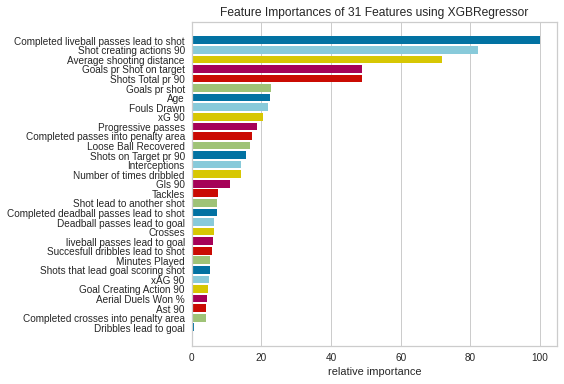

In [215]:
# Feature importance

viz = FeatureImportances(model_xgb_FW)
viz.fit(data_FW, y_FW)
viz.show()

In [216]:
explainer_FW = shap.TreeExplainer(model_xgb_FW)

In [217]:
shap_values_FW = explainer_FW.shap_values(data_FW)

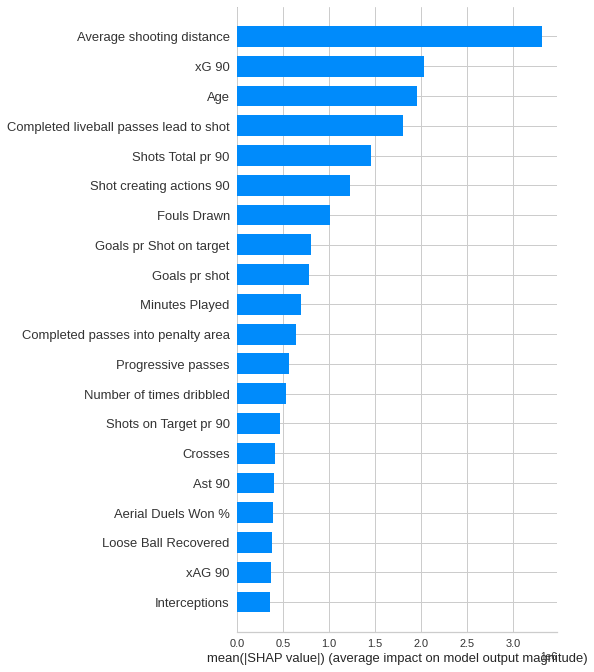

In [218]:
shap.summary_plot(shap_values_FW, data_FW, plot_type="bar")

##Goalkeepers

In [219]:
y_GK = dataGK[["market_value"]]

In [220]:
dataX_GK = dataGK.drop(['market_value', 'index'], axis=1)

In [221]:
X_GK_scaled = scaler.fit_transform(dataX_GK.iloc[:,5:])

In [222]:
dataX_GK.iloc[:,5:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Minutes Played                       152 non-null    int64  
 1   Goals Against 90                     152 non-null    float64
 2   Save%                                152 non-null    float64
 3   Clean Sheet%                         152 non-null    float64
 4   Age                                  152 non-null    float64
 5   GA                                   152 non-null    float64
 6   FK                                   152 non-null    float64
 7   CK                                   152 non-null    float64
 8   Own Goals scored against the keeper  152 non-null    float64
 9   Post shot xG                         152 non-null    float64
 10  PSxG+/-                              152 non-null    float64
 11  Cmp                             

In [223]:
X_GK_scaled = pd.DataFrame(X_GK_scaled, columns=["Minutes Played","Goals Against 90","Save%","Clean Sheet%","Age","GA","FK","CK","Own Goals scored against the keeper","Post shot xG","PSxG+/-","Cmp","Att2","Launch%","Opp","Stp%","#OPA/90"])

In [224]:
dataX_GK = pd.concat([dataX_GK.iloc[:,:5], X_GK_scaled], axis=1)

In [225]:
#Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataX_GK.iloc[:,5:], y_GK, test_size = 0.2)

In [226]:
# Instanciating XGBRegressor
model_xgb_GK = XGBRegressor(n_estimators=5000, learning_rate=0.005, max_depth=3, colsample_bytree=0.3)

In [227]:
# Fitting to train data
model_xgb_GK.fit(X_train, y_train)

[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.3, learning_rate=0.005, n_estimators=5000)

In [228]:
print('Model XGB for goalkeepers train score:' + ' ' + str(model_xgb_GK.score(X_train, y_train)))
print('Model XGB for goalkeepers test score :' + ' ' + str(model_xgb_GK.score(X_test, y_test)))

Model XGB for goalkeepers train score: 0.9997657751633958
Model XGB for goalkeepers test score : 0.31803420413552586


#Exporting the models

In [229]:
import pickle

In [230]:
model_xgb.save_model('model_xgb.json')

In [231]:
pickle.dump(scaler, open('scaler.pkl','wb'))

In [232]:
pickle.dump(ohe_X, open('ohe.pkl','wb'))

In [233]:
dataX.to_json('dataX.json')
data.to_json('data.json')

In [234]:
pickle.dump(model_xgb, open('model_xgb.pkl','wb'))

In [235]:
pickle.dump(shap_values, open('shap_values.pkl','wb'))